In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

#print(tf.__version__)


2024-06-04 15:59:06.211353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hsibitenda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hsibitenda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_csv('../harriet/traindataset.csv')
df.shape

(3683, 34)

In [7]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma'],
      dtype='object')

In [8]:
# df=df2.copy()
df=df.astype(str)

In [9]:
from nltk.corpus import stopwords
from collections import Counter

# Define your custom stop words
custom_stopwords = set(stopwords.words('english'))

# Counting word frequency
cnt = Counter()
for text in df["Text_lemma"].values:
    for word in text.split():
        cnt[word] += 1

# Retrieve the first 20 most common words
most_common_words = [word for word, _ in cnt.most_common(20)]

# Add the first 20 most common words to the custom stop words
custom_stopwords.update(most_common_words)

# Remove common words from the text using the stop words
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in custom_stopwords)

df["Text_lemma"] = df["Text_lemma"].apply(remove_stopwords)
# MAX_LEN=200
docs = df["Text_lemma"].values
# docs = [' '.join(doc.split()[:MAX_LEN]) for doc in df['Text_lemma'].values]
tokenized = df['Text_lemma'].apply(lambda x: x.split()) # tokenizing
tokenized_docs = tokenized.values


In [10]:

from collections import Counter
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)
vocab.most_common(10)


[('video', 6490),
 ('covid', 6450),
 ('african', 5998),
 ('state', 5771),
 ('problem', 5732),
 ('time', 5677),
 ('challenge', 5573),
 ('also', 5449),
 ('reactionsm', 5394),
 ('medium', 5205)]

In [11]:
df1=df.copy()

In [12]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma'],
      dtype='object')

In [3]:
df.shape

(22036, 29)

In [3]:
# encoding with https://huggingface.co/sentence-transformers
# tokenize with BERT
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer #AutoModel, TFBertModel, TFAutoModel

MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [5]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import umap
import numpy as np

# Assuming the DataFrame is already created and named df
# df = pd.read_csv('your_data.csv')  # Example to load DataFrame

# Define model and tokenizer
MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
embedding_model = SentenceTransformer(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 200

# Tokenize the documents and limit to MAX_LEN tokens
encoding = tokenizer(
    text=df['Text_lemma'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=MAX_LEN,
    truncation=True,
    pad_to_max_length=True,
    verbose=True
)

# Convert tokenized input to embeddings using SentenceTransformer
documents = [' '.join(doc.split()[:MAX_LEN]) for doc in df['Text_lemma'].values]
embeddings = embedding_model.encode(documents, convert_to_tensor=True)

# Move the tensor to CPU and convert to NumPy array
embeddings_cpu = embeddings.cpu().numpy()

# Apply UMAP on the embeddings
X_embedded = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings_cpu)

# Now X_embedded contains the dimensionality-reduced embeddings


/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
# X_embedded = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

# embeddings = encoding['input_ids']

In [17]:
# from sentence_transformers import SentenceTransformer

# # Pre-calculate embeddings
# embedding_model = SentenceTransformer("BAAI/bge-small-en")
# embeddings = embedding_model.encode(df['Text_lemma'], show_progress_bar=True)
# # embeddings = embedding_model.encode(df['Document'], show_progr>ess_bar=True)

In [18]:

# # import warnings
# # warnings.filterwarnings('ignore')
# # import umap
# # X_embedded = umap.UMAP(n_neighbors=15,
# #                             n_components=5,
# #                             metric='cosine').fit_transform(embeddings)
# # matrix = matrix
# import warnings
# warnings.filterwarnings('ignore')
# import umap
# # X_embedded = umap.UMAP(n_neighbors=15,
# #                             n_components=5,
# #                             metric='cosine').fit_transform(embeddings)
# X_embedded = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)


In [19]:

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', min_samples= 15,
                          cluster_selection_method='eom').fit(X_embedded)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [20]:
from sklearn.metrics import silhouette_score
silhouette_score(X_embedded, cluster.labels_)

0.08781424

In [21]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma'],
      dtype='object')

In [22]:
# df1.columns

In [23]:
# df=df.astype(str)
# df=df1.copy()

In [24]:

#df = pd.DataFrame(df, columns=["Doc"])
df['berttopic2'] = cluster.labels_
df['cluster_id2']= df['berttopic2']
#df['Doc_ID'] = range(len(df))


In [25]:

docs_per_topic = df.groupby(['cluster_id2'], as_index = False).agg({'Text_lemma': ' '.join})
docs_per_topic

,cluster_id2,Text_lemma
0,-1,weektrademarks side event oct todayconfusion w...
1,0,china president xi jinping dw documentary dw d...
2,1,teaching v rest vox reactionsm collapse venezu...
3,2,afghanistan taliban cant defeated economist re...
4,3,uganda medium row raise question regulation iv...
...,...,...
299,298,apply changemakers innovation challenge today ...
300,299,sa water crisis nelson mandela bay water issue...
301,300,vg daily ep green deal part problem climate ch...
302,301,summit vision kasarani indoor stadium congrega...


In [26]:
import os
import subprocess
import getpass
from huggingface_hub import notebook_login

# Define the path to the token file
token_file_path = "/home/hsibitenda/scratch/harriet/llms/huggingface_token.txt"  # Replace with the actual path

if os.path.exists(token_file_path):
    # If the token file exists, read the token from the file
    with open(token_file_path, "r") as file:
        token = file.read().strip()
else:
    # If the token file does not exist, prompt the user to enter the token securely
    print("Please enter your Hugging Face token:")
    token = getpass.getpass()

# Set up the environment variable with the token
os.environ["HUGGINGFACE_TOKEN"] = token

# Use transformers-cli to login
command = f'transformers-cli login --token {token}'
subprocess.run(command, shell=True)

Please enter your Hugging Face token:


 ········


usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: unrecognized arguments: --token


CompletedProcess(args='transformers-cli login --token ', returncode=2)

In [27]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

#print(device)

In [28]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [29]:
import transformers
import torch


# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id, max_length=128)

# Load Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=None,  # No quantization config provided
)

# Convert model parameters to bfloat16
for param in model.parameters():
    param.data = param.data.to(torch.bfloat16)

# Set the model to evaluation mode
model.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [30]:


# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

In [31]:


# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [32]:


# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 
'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. 
Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [33]:

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

In [34]:

prompt = system_prompt + example_prompt + main_prompt

In [35]:
# df12=df.head(50)
# df=df12.copy()

In [36]:
# # from sentence_transformers import SentenceTransformer

# # Pre-calculate embeddings
# embedding_model = SentenceTransformer("BAAI/bge-small-en")
# embeddings = embedding_model.encode(df['Text_lemma'], show_progress_bar=True)
# # embeddings = embedding_model.encode(df['Document'], show_progr>ess_bar=True)

In [37]:
# # matrix = matrix
# import warnings
# warnings.filterwarnings('ignore')
# import umap
# # X_embedded = umap.UMAP(n_neighbors=15,
# #                             n_components=5,
# #                             metric='cosine').fit_transform(embeddings)
# X_embedded = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)


In [38]:


import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Text_lemma.values, m=len(X_embedded))

In [39]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.cluster_id2)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i,
                   label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster_id2'])
                     .Text_lemma
                     .count()
                     .reset_index()
                     .rename(columns={"cluster_id2": "Topic", "Text_lemma": "Size"})
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Initialize the number of topics
num_topics = df['cluster_id2'].nunique()
# Continue until the number of topics is 20 or below
while num_topics > 10:
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract labels to merge into and from where
    topic_sizes = df.groupby(['cluster_id2']).count().sort_values("Text_lemma", ascending=False).reset_index()
    topics_to_merge = topic_sizes.iloc[-10:].cluster_id2.tolist()  # Choose the top 10 topics to merge
    
    for topic_to_merge in topics_to_merge:
        # Ensure that the index is within the valid range
        if topic_to_merge + 1 < len(similarities):
            topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1])
            
            # Adjust topics
            df.loc[df.cluster_id2 == topic_to_merge, "cluster_id2"] = topic_to_merge_into
            old_topics = df.sort_values("cluster_id2").cluster_id2.unique()
            map_topics = {old_topic: index for index, old_topic in enumerate(old_topics)}
            df.cluster_id2 = df.cluster_id2.map(map_topics)
        
    docs_per_topic = df.groupby(['cluster_id2'], as_index=False).agg({'Text_lemma': ' '.join})

    # Calculate new topic words
    m = len(embeddings)
    tf_idf, count = c_tf_idf(docs_per_topic.Text_lemma.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

    # Update the number of topics
    num_topics = df['cluster_id2'].nunique()
    
    print(f"Number of topics: {num_topics}")
topic_sizes = extract_topic_sizes(df)
top_n_words


Number of topics: 295
Number of topics: 286
Number of topics: 277
Number of topics: 268
Number of topics: 260
Number of topics: 252
Number of topics: 244
Number of topics: 236
Number of topics: 228
Number of topics: 220
Number of topics: 212
Number of topics: 203
Number of topics: 194
Number of topics: 185
Number of topics: 176
Number of topics: 168
Number of topics: 160
Number of topics: 152
Number of topics: 146
Number of topics: 140
Number of topics: 135
Number of topics: 130
Number of topics: 125
Number of topics: 120
Number of topics: 115
Number of topics: 110
Number of topics: 105
Number of topics: 99
Number of topics: 93
Number of topics: 87
Number of topics: 81
Number of topics: 75
Number of topics: 69
Number of topics: 63
Number of topics: 56
Number of topics: 50
Number of topics: 46
Number of topics: 41
Number of topics: 38
Number of topics: 34
Number of topics: 29
Number of topics: 22
Number of topics: 16
Number of topics: 10


{0: [('covid', 0.004264753010553059),
  ('african', 0.004132396355870341),
  ('time', 0.004105565743630238),
  ('video', 0.004008177708356928),
  ('nigeria', 0.003935928529495938),
  ('visa', 0.003928455561424404),
  ('medium', 0.0039184777286674615),
  ('passport', 0.003855947504467974),
  ('state', 0.0038488254771742152),
  ('driver', 0.003823655697035549)],
 1: [('frontline', 0.13126725145605064),
  ('pb', 0.08563254354865356),
  ('documentaryconfusion', 0.07623193885681112),
  ('reactionsm', 0.07484238945339566),
  ('spiritualist', 0.07330123792427921),
  ('traveling', 0.06590773702997366),
  ('solved', 0.06149399396263008),
  ('official', 0.05315088473705128),
  ('infertility', 0.05224802639715868),
  ('spirit', 0.051712925028530234)],
 2: [('pitbull', 0.28214703242386613),
  ('washington', 0.19640066856094782),
  ('schumer', 0.159469559757918),
  ('oncamera', 0.15547237511813597),
  ('pelosi', 0.15287422840258238),
  ('shouting', 0.13958144630617214),
  ('post', 0.137517314120056

In [41]:
# Generate topic labels using the given prompts
def generate_labels(prompt, top_n_words):
    # Initialize an empty list to store labels
    labels = []
    # Iterate over each topic's top words
    for topic, words in top_n_words.items():
        # Join the words with commas
        word_str = ', '.join([word[0] for word in words])
        # Replace [DOCUMENTS] tag with the topic's top words
        prompt_with_words = prompt.replace("[KEYWORDS]", word_str)
        # Generate the label using the prompt
        label = generator(prompt_with_words)[0]['generated_text'].split('\n')[-1].strip()
        # Append the label to the list
        labels.append(label)
    return labels

# Generate labels using the main prompt
labels = generate_labels(main_prompt, top_n_words)

# Add labels to the DataFrame
docs_per_topic['llama2_labelswsp'] = labels

# Save the DataFrame to a new CSV file
# df.to_csv('labeled_topics.csv', index=False)
docs_per_topic


,cluster_id2,Text_lemma,llama2_labelswsp
0,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio..."
1,1,katy perry wide awake official videoconfusion ...,"""Spiritual Journey Through Infertility"""
2,2,pitbull option official videoconfusion ft step...,"""Pitbulls in Washington: Shouting Match betwee..."
3,3,sa water crisis nelson mandela bay water issue...,"""Entrepreneurial Innovation in Energy & Enviro..."
4,4,gravitas plus explainetonguestickingoutcheekyp...,"""Nicki Minaj Reactions at Davos and Biden's Da..."
5,5,look network horrified speak directly without ...,"""China's Rise in Global Politics: Prosperity, ..."
6,6,creator famous sophia robot reveal ai robotics...,"Sure! Based on the keywords provided, I would ..."
7,7,creator hebrew negro film reacts kyrie irving ...,"""Reactions to Godsent's Anxiety-Inducing Video..."
8,8,diver accidentally made chilling discovery exp...,"""Tillerson-Trump controversy involving Balvin,..."
9,9,age ai full documentaryconfusion frontline fro...,"""Spiritual Infertility Consultation"""


In [42]:
new = pd.DataFrame(top_n_words.items(), columns=['cluster_id2', 'cluster_label'])

new

,cluster_id2,cluster_label
0,0,"[(covid, 0.004264753010553059), (african, 0.00..."
1,1,"[(frontline, 0.13126725145605064), (pb, 0.0856..."
2,2,"[(pitbull, 0.28214703242386613), (washington, ..."
3,3,"[(challenge, 0.045760477078369714), (innovatio..."
4,4,"[(nicki, 0.1313074865784844), (minaj, 0.130360..."
5,5,"[(china, 0.2180207519568891), (pres, 0.1027027..."
6,6,"[(robot, 0.2826774669665731), (harvard, 0.2086..."
7,7,"[(reactionsm, 0.04674616431531839), (godsent, ..."
8,8,"[(tillerson, 0.1345493816360408), (trump, 0.10..."
9,9,"[(charm, 0.31959076767138783), (thetop, 0.2050..."


In [43]:
import string
#df_labels= pd.DataFrame(top_n_words.items(), columns=['Topicbert', 'Label'])
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r"[!@#$]", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\x00-\x7f]', "", text) # non ASCII characters


    text = text.replace('\n', ' ')# replace new line into space
#     text = text.replace("[^\w\s]","")
#     text = text.replace("@\w+ ?","")# mentions
#     text = text.replace("\d","")# remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    text = text.replace(' ', '_')# replace new line into space
    return text
new['cluster_label'] = new['cluster_label'] .astype(str)
new['cluster_label'] = new['cluster_label'] .apply(cleaningText)
new.head()

,cluster_id2,cluster_label
0,0,covid__african__time__video__nigeria__visa__me...
1,1,frontline__pb__documentaryconfusion__reactions...
2,2,pitbull__washington__schumer__oncamera__pelosi...
3,3,challenge__innovation__energy__amp__entreprene...
4,4,nicki__minaj__reactionsm__pb__dw__davos__biden...


In [44]:
docs_per_topic = docs_per_topic.merge(new, left_on='cluster_id2', right_on='cluster_id2')
docs_per_topic

,cluster_id2,Text_lemma,llama2_labelswsp,cluster_label
0,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...
1,1,katy perry wide awake official videoconfusion ...,"""Spiritual Journey Through Infertility""",frontline__pb__documentaryconfusion__reactions...
2,2,pitbull option official videoconfusion ft step...,"""Pitbulls in Washington: Shouting Match betwee...",pitbull__washington__schumer__oncamera__pelosi...
3,3,sa water crisis nelson mandela bay water issue...,"""Entrepreneurial Innovation in Energy & Enviro...",challenge__innovation__energy__amp__entreprene...
4,4,gravitas plus explainetonguestickingoutcheekyp...,"""Nicki Minaj Reactions at Davos and Biden's Da...",nicki__minaj__reactionsm__pb__dw__davos__biden...
5,5,look network horrified speak directly without ...,"""China's Rise in Global Politics: Prosperity, ...",china__pres__prosperity__risen__viewsas__influ...
6,6,creator famous sophia robot reveal ai robotics...,"Sure! Based on the keywords provided, I would ...",robot__harvard__sophia__taliban__defeated__eco...
7,7,creator hebrew negro film reacts kyrie irving ...,"""Reactions to Godsent's Anxiety-Inducing Video...",reactionsm__godsent__anxiety__solving__reactio...
8,8,diver accidentally made chilling discovery exp...,"""Tillerson-Trump controversy involving Balvin,...",tillerson__trump__balvin__nbc__tillersons__tra...
9,9,age ai full documentaryconfusion frontline fro...,"""Spiritual Infertility Consultation""",charm__thetop__naaba__consult__luck__infertili...


In [45]:
df = df.merge(docs_per_topic, left_on='cluster_id2', right_on='cluster_id2')

In [46]:
# # Add labels to the DataFrame
# df['llama2_labels'] = labels

# # Save the DataFrame to a new CSV file
# # df.to_csv('labeled_topics.csv', index=False)
# df
df.shape

(22036, 28)

In [47]:
df.head()

,Unnamed: 0.1,Unnamed: 0,textid,Date,Views,sourcetype,alltext,Text_emt,Text_emj,Text_langue,...,Text_translate2,Text_token,Text_stop,Text_stem,Text_lemma_x,berttopic2,cluster_id2,Text_lemma_y,llama2_labelswsp,cluster_label
0,7930,8155,7969,2022-10-24 07:28:48+00:00,11,twitter,This weekâ€™s 3 #WCEF2022 side events:\n\nðŸŸ¡...,This weekâ€™s 3 #WCEF2022 side events:\n\nðŸŸ¡...,This weekâ€trade_marks 3 #WCEF2022 side events...,en,...,this weektrademarks side events oct todayconfu...,"['this', 'weektrademarks', 'side', 'events', '...",weektrademarks side events oct todayconfusion ...,weektrademark side event oct todayconfus wast ...,weektrademarks side event oct todayconfusion w...,-1,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...
1,2323,2378,2336,2020-11-07 14:41:09+00:00,1,twitter,@shutup_Bob Tell me would you allow an influx ...,@shutup_Bob Tell me would you allow an influx ...,@shutup_Bob Tell me would you allow an influx ...,en,...,bob tell me would you allow an influx of afric...,"['bob', 'tell', 'me', 'would', 'you', 'allow',...",bob tell would allow influx africans south afr...,bob tell would allow influx african south afri...,bob tell would allow influx african burdening ...,285,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...
2,22573,12851,22722,2023-08-20,529,youtube,ap 6th class social studies fa3 original pap...,ap 6th class social studies fa3 original pap...,ap 6th class social studies fa3 original pap...,en,...,ap th class social studies fa original paper l...,"['ap', 'th', 'class', 'social', 'studies', 'fa...",ap th class social studies fa original paper l...,ap th class social studi fa origin paper leak ...,ap th class study fa original paper leaked fa ...,223,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...
3,4692,4824,4717,2021-11-17 16:39:01+00:00,2,twitter,Blinken is actually on a social vist to B. Hus...,Blinken is actually on a social vist to B. Hus...,Blinken is actually on a social vist to B. Hus...,en,...,blinken is actually on a social vist to b huss...,"['blinken', 'is', 'actually', 'on', 'a', 'soci...",blinken actually social vist b hussein obama k...,blinken actual social vist b hussein obama ken...,blinken actually vist b hussein obama kenyan b...,-1,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...
4,24318,14904,24491,2018-08-24,234,youtube,The Weeknd - Secrets (Official Video) by The...,The Weeknd - Secrets (Official VideoConfusio...,The Weeknd - Secrets (Official VideoConfusio...,en,...,the weeknd secrets official videoconfusion by ...,"['the', 'weeknd', 'secrets', 'official', 'vide...",weeknd secrets official videoconfusion weeknd ...,weeknd secret offici videoconfus weeknd year a...,weeknd secret official videoconfusion weeknd r...,32,0,weektrademarks side event oct todayconfusion w...,"""African countries' COVID-19 travel restrictio...",covid__african__time__video__nigeria__visa__me...


In [48]:
df['cluster_id']= df['berttopic2']

In [49]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma_x', 'berttopic2', 'cluster_id2',
       'Text_lemma_y', 'llama2_labelswsp', 'cluster_label', 'cluster_id'],
      dtype='object')

In [50]:
docs_per_topic = df.groupby(['cluster_id'], as_index = False).agg({'Text_lemma_x': ' '.join})
docs_per_topic

,cluster_id,Text_lemma_x
0,-1,weektrademarks side event oct todayconfusion w...
1,0,china president xi jinping dw documentary dw d...
2,1,teaching v rest vox reactionsm collapse venezu...
3,2,afghanistan taliban cant defeated economist re...
4,3,uganda medium row raise question regulation iv...
...,...,...
299,298,apply changemakers innovation challenge today ...
300,299,sa water crisis nelson mandela bay water issue...
301,300,vg daily ep green deal part problem climate ch...
302,301,summit vision kasarani indoor stadium congrega...


In [51]:
# df['cluster_id']=df[['cluster_id2']]

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.cluster_id)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i,
                   label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster_id'])
                     .Text_lemma_x
                     .count()
                     .reset_index()
                     .rename(columns={"cluster_id": "Topic", "Text_lemma_x": "Size"})
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Initialize the number of topics
num_topics = df['cluster_id'].nunique()
# Calculate cosine similarity
similarities = cosine_similarity(tf_idf.T)
np.fill_diagonal(similarities, 0)

# Extract labels to merge into and from where
topic_sizes = df.groupby(['cluster_id']).count().sort_values("Text_lemma_x", ascending=False).reset_index()
topics_to_merge = topic_sizes.iloc[-10:].cluster_id.tolist()  # Choose the top 10 topics to merge

for topic_to_merge in topics_to_merge:
    # Ensure that the index is within the valid range
    if topic_to_merge + 1 < len(similarities):
        topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1])

        # Adjust topics
        df.loc[df.cluster_id == topic_to_merge, "cluster_id"] = topic_to_merge_into
        old_topics = df.sort_values("cluster_id").cluster_id.unique()
        map_topics = {old_topic: index for index, old_topic in enumerate(old_topics)}
        df.cluster_id = df.cluster_id.map(map_topics)

docs_per_topic = df.groupby(['cluster_id'], as_index=False).agg({'Text_lemma_x': ' '.join})

# Calculate new topic words
m = len(embeddings)
tf_idf, count = c_tf_idf(docs_per_topic.Text_lemma_x.values, m)
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

topic_sizes = extract_topic_sizes(df)
top_n_words


{-1: [('visa', 0.006139517684021624),
  ('driver', 0.005509794940688382),
  ('passport', 0.005448670834274685),
  ('license', 0.005409681428466925),
  ('apply', 0.005303877490501204),
  ('buy', 0.004852266928201829),
  ('grant', 0.004747487373838379),
  ('time', 0.0047457482761058736),
  ('african', 0.004402104701559594),
  ('australia', 0.004369122517062769)],
 0: [('dw', 0.640072412839889),
  ('documentary', 0.596284970001053),
  ('jinping', 0.4369574896590856),
  ('xi', 0.3405731061977137),
  ('china', 0.2811135314377547),
  ('hour', 0.14362922272139925),
  ('president', 0.11427873686264088),
  ('month', 0.11420883787048006),
  ('surveillance', 0.1125764360748703),
  ('reactionsk', 0.10174246894240097)],
 1: [('vox', 1.0116117323633467),
  ('segregated', 0.42651295789653487),
  ('reactionsm', 0.28458258830555605),
  ('venezuela', 0.23490863404221995),
  ('explained', 0.1739917132179882),
  ('collapse', 0.17268852391667397),
  ('map', 0.14342555232909845),
  ('nced', 0.12667850584518

In [53]:
df.shape

(22036, 29)

In [54]:
# Generate topic labels using the given prompts
def generate_labels(prompt, top_n_words):
    # Initialize an empty list to store labels
    labels = []
    # Iterate over each topic's top words
    for topic, words in top_n_words.items():
        # Join the words with commas
        word_str = ', '.join([word[0] for word in words])
        # Replace [DOCUMENTS] tag with the topic's top words
        prompt_with_words = prompt.replace("[KEYWORDS]", word_str)
        # Generate the label using the prompt
        label = generator(prompt_with_words)[0]['generated_text'].split('\n')[-1].strip()
        # Append the label to the list
        labels.append(label)
    return labels

# Generate labels using the main prompt
labels = generate_labels(main_prompt, top_n_words)

# Add labels to the DataFrame
docs_per_topic['llama2_labelone'] = labels

# Save the DataFrame to a new CSV file
# df.to_csv('labeled_topics.csv', index=False)
docs_per_topic


,cluster_id,Text_lemma_x,llama2_labelone
0,-1,weektrademarks side event oct todayconfusion w...,"Sure! Based on the keywords provided, I would ..."
1,0,china president xi jinping dw documentary dw d...,"""China's Surveillance State Under Xi Jinping"""
2,1,teaching v rest vox reactionsm collapse venezu...,Venezuela Political Collapse Explained
3,2,afghanistan taliban cant defeated economist re...,Taliban Defeated in Afghanistan
4,3,uganda medium row raise question regulation iv...,"""Uganda Regulation Row"""
...,...,...,...
299,298,apply changemakers innovation challenge today ...,Innovative Nonprofit Changemakers for Africa's...
300,299,sa water crisis nelson mandela bay water issue...,Water & Environmental Challenge: Innovating fo...
301,300,vg daily ep green deal part problem climate ch...,"""Climate Change Impacts in Tilburg: Vulnerabil..."
302,301,summit vision kasarani indoor stadium congrega...,"""African Trademarks: Solving Biggest Business ..."


In [55]:
new = pd.DataFrame(top_n_words.items(), columns=['cluster_id', 'cluster_labelone'])

new

,cluster_id,cluster_labelone
0,-1,"[(visa, 0.006139517684021624), (driver, 0.0055..."
1,0,"[(dw, 0.640072412839889), (documentary, 0.5962..."
2,1,"[(vox, 1.0116117323633467), (segregated, 0.426..."
3,2,"[(taliban, 1.099093975921278), (defeated, 1.08..."
4,3,"[(row, 0.7017035166063398), (regulation, 0.585..."
...,...,...
299,298,"[(changemakers, 0.6337978952262427), (nonprofi..."
300,299,"[(water, 0.0861974563090488), (environmental, ..."
301,300,"[(climate, 0.2928560168729546), (change, 0.174..."
302,301,"[(idea, 0.2152892336510182), (solving, 0.16841..."


In [56]:
import string
#df_labels= pd.DataFrame(top_n_words.items(), columns=['Topicbert', 'Label'])
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r"[!@#$]", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\x00-\x7f]', "", text) # non ASCII characters


    text = text.replace('\n', ' ')# replace new line into space
#     text = text.replace("[^\w\s]","")
#     text = text.replace("@\w+ ?","")# mentions
#     text = text.replace("\d","")# remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    text = text.replace(' ', '_')# replace new line into space
    return text
new['cluster_labelone'] = new['cluster_labelone'] .astype(str)
new['cluster_labelone'] = new['cluster_labelone'] .apply(cleaningText)
new.head()

,cluster_id,cluster_labelone
0,-1,visa__driver__passport__license__apply__buy__g...
1,0,dw__documentary__jinping__xi__china__hour__pre...
2,1,vox__segregated__reactionsm__venezuela__explai...
3,2,taliban__defeated__economist__afghanistan__rea...
4,3,row__regulation__raise__uganda__question__medi...


In [57]:
docs_per_topic = docs_per_topic.merge(new, left_on='cluster_id', right_on='cluster_id')
docs_per_topic

,cluster_id,Text_lemma_x,llama2_labelone,cluster_labelone
0,-1,weektrademarks side event oct todayconfusion w...,"Sure! Based on the keywords provided, I would ...",visa__driver__passport__license__apply__buy__g...
1,0,china president xi jinping dw documentary dw d...,"""China's Surveillance State Under Xi Jinping""",dw__documentary__jinping__xi__china__hour__pre...
2,1,teaching v rest vox reactionsm collapse venezu...,Venezuela Political Collapse Explained,vox__segregated__reactionsm__venezuela__explai...
3,2,afghanistan taliban cant defeated economist re...,Taliban Defeated in Afghanistan,taliban__defeated__economist__afghanistan__rea...
4,3,uganda medium row raise question regulation iv...,"""Uganda Regulation Row""",row__regulation__raise__uganda__question__medi...
...,...,...,...,...
299,298,apply changemakers innovation challenge today ...,Innovative Nonprofit Changemakers for Africa's...,changemakers__nonprofit__enterprise__innovatio...
300,299,sa water crisis nelson mandela bay water issue...,Water & Environmental Challenge: Innovating fo...,water__environmental__climate__challenge__inno...
301,300,vg daily ep green deal part problem climate ch...,"""Climate Change Impacts in Tilburg: Vulnerabil...",climate__change__tilburguniversity__tilburg__b...
302,301,summit vision kasarani indoor stadium congrega...,"""African Trademarks: Solving Biggest Business ...",idea__solving__africatrademarks__biggest__shar...


In [58]:
df = df.merge(docs_per_topic, left_on='cluster_id', right_on='cluster_id')

In [59]:
df.shape

(22036, 32)

In [ ]:
docs_per_topic

In [60]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma_x_x', 'berttopic2', 'cluster_id2',
       'Text_lemma_y', 'llama2_labelswsp', 'cluster_label', 'cluster_id',
       'Text_lemma_x_y', 'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [62]:
df['Text_lemma']=df[['Text_lemma_x_x']]
df['cluster_labelone10']=df[['cluster_label']]
df['llama2_labelone10']=df[['llama2_labelswsp']]
df2=df[['textid', 'Date', 'Views', 'sourcetype',
       'alltext', 'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate',
       'Text_langue2', 'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat',
       'Text_spell', 'Text_langue3', 'Text_translate2', 'Text_token',
       'Text_stop', 'Text_stem', 'Text_lemma','berttopic2', 'cluster_id2','llama2_labelone10','cluster_labelone10', 'cluster_id','llama2_labelone', 'cluster_labelone']]
df2.shape

(22036, 28)

In [63]:
df=df2.copy()
df.to_csv('BERT-CTFIDF.csv')#, index=False)


In [3]:
# df['cluster_id'].unique()

In [4]:
# df['berttopic2'].unique()

In [96]:
# df['label_Llama2'].count()

In [97]:
# df['CustomName'][30]

In [4]:
df.columns

Index(['Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype', 'alltext',
       'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate', 'Text_langue2',
       'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat', 'Text_spell',
       'Text_langue3', 'Text_translate2', 'Text_token', 'Text_stop',
       'Text_stem', 'Text_lemma', 'berttopic2', 'cluster_id2',
       'llama2_labelone10', 'cluster_labelone10', 'cluster_id',
       'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [3]:
df=pd.read_csv('BERT-CTFIDF.csv')#, index=False)
df=df.astype(str)

In [6]:

from sklearn import model_selection 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import urllib
from sklearn import neighbors
import warnings
warnings.filterwarnings('ignore')
#------------------------------------Metrics and Validation---------------------------------------------------------#
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
#-------------------------------------Models to be trained----------------------------------------------------------#
from sklearn.ensemble import StackingClassifier, VotingClassifier
import xgboost
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('figure', titlesize=35)
plt.rc('legend', fontsize=12)
avg_accuracies={}
accuracies={}
roc_auc={}
pr_auc={}
def conf_matrix(ytest,pred):
    plt.figure(figsize=(9,6))
    global cm1
    cm1 = confusion_matrix(ytest, pred)
    ax=sns.heatmap(cm1, annot= True, cmap='Blues')
    plt.title('Confusion Matrix',pad=20)
def metrics_score(cm):
    total=sum(sum(cm))
    accuracy=(cm[0,0]+cm[1,1])/total
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    specificity = cm[0,0]/(cm[0,1]+cm[0,0])
    values=[np.round(accuracy*100,3),np.round(precision*100,3),np.round(sensitivity*100,3),np.round(f1*100,3),np.round(specificity*100,3)]
    plt.figure(figsize=(15,8))
    sns.set_palette('magma')
    ax=sns.barplot(x=['Accuracy','Precision','Recall','F1 score','Specificity'],y=values)
    plt.yticks(np.arange(0,100,10))
    plt.ylabel('Percentage %',labelpad=10)
    plt.xlabel('Scoring Parameter',labelpad=10)
    plt.title('Metrics Scores',pad=20)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x()+0.3,p.get_height()+1.02))
    plt.show()
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='Orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.ylabel('True Positive Rate',labelpad=10)
    plt.xlabel('False Positive Rate',labelpad=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve',pad=20)
    plt.legend()
    plt.show()
def plot_precision_recall_curve(recall, precision):
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='orange', label='PRC')
    plt.ylabel('Precision',labelpad=10)
    plt.xlabel('Recall',labelpad=10)
    plt.title('Precision Recall Curve',pad=20)
    plt.legend()
    plt.show()
# Scaling X_embedded
X_embedded = preprocessing.scale(X_embedded)

# Defining target variable
y = df[['llama2_labelone']].values

# Splitting the data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_embedded, y, test_size=0.2, random_state=42, stratify=y)

# Apply UMAP only on the training data
umap_transformer = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
x_train = umap_transformer.fit_transform(x_train)

# Transform the test data using the fitted UMAP transformer
x_test = umap_transformer.transform(x_test)




# get a list of models to evaluate
from sklearn.neural_network import MLPClassifier

def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['RF'] = RandomForestClassifier()
    models['bayes'] = GaussianNB()
    models['MLP']=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    
    return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# Define cross-validation strategy
# cv = StratifiedKFold(n_splits=p_cv, random_state=100, shuffle=True)
# cv = model_selection.StratifiedKFold(n_splits=p_cv, random_state=100, shuffle=True)
bayes=GaussianNB()
# bayes = GaussianNB(bayes, param_grid=None, cv=cv, scoring=p_score, n_jobs=-1, verbose=1)
bayes.fit(x_train, y_train)

lr=LogisticRegression()
lr.fit(x_train, y_train)

knn=KNeighborsClassifier()
knn.fit(x_train, y_train)

cart=DecisionTreeClassifier()
cart.fit(x_train, y_train)

svm=SVC(probability=True)
svm.fit(x_train, y_train)

RF=RandomForestClassifier()
RF.fit(x_train, y_train)
MLP=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
MLP.fit(x_train, y_train)

# from lightgbm import
prediction1 = bayes.predict(x_test)
accuracy1 = bayes.score(x_test, y_test) 

prediction2 = lr.predict(x_test)
accuracy2 = lr.score(x_test, y_test) 

prediction3 = knn.predict(x_test)
accuracy3 = knn.score(x_test, y_test) 

prediction4 = cart.predict(x_test)
accuracy4 = cart.score(x_test, y_test) 

prediction5 = svm.predict(x_test)
accuracy5 = svm.score(x_test, y_test) 

prediction6 = MLP.predict(x_test)
accuracy6 = MLP.score(x_test, y_test) 

prediction7 = RF.predict(x_test)
accuracy7 = RF.score(x_test, y_test) 
estimators = [
    ('lr', lr),
    ('knn', knn),
    ('cart', cart),
    ('svm', svm),
    ('RF', RF),
    ('bayes', bayes),
    ('MLP', MLP)
]

# estimators

model_voting = VotingClassifier(
    estimators = estimators,
    voting='soft', 
    n_jobs=-1,
    flatten_transform=True, 
    verbose=1).fit(x_train, y_train)

model_voting.score(x_train, y_train)
prediction8=model_voting.predict(x_test)
accuracy8 = model_voting.score(x_test, y_test)
print(classification_report(y_test, prediction8))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                                                                                                           "African Comedian Reacts to Ragghana Street Funny Quiz Video"       1.00  

In [7]:
accuracies['lr'] = np.round(accuracy1 * 100,3)

accuracies['knn'] = np.round(accuracy2 * 100,3)

accuracies['cart'] = np.round(accuracy3 * 100,3)

accuracies['svm'] = np.round(accuracy4 * 100,3)

accuracies['bayes'] = np.round(accuracy5 * 100,3)

accuracies['MLP'] = np.round(accuracy6 * 100,3)
accuracies['RF'] = np.round(accuracy7 * 100,3)

accuracies['model_voting'] = np.round(accuracy8 * 100,3)

In [8]:
import joblib
xgc = xgboost.XGBClassifier()

model_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=xgc,
    n_jobs = -1,
    verbose = 1
)

model_stack.fit(x_train, y_train)

#model_stack.score(x_train, y_train)
# Get the training accuracy
train_accuracy2 = model_stack.score(x_train, y_train)

# Save the trained model using joblib
joblib.dump(model_stack, 'stack_classifier_modelwsp2.pkl')

# Write the performance details to a text file
with open('model_performancewsp2.txt', 'w') as f:
    f.write("Training Accuracy: {}\n".format(train_accuracy2))

/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBacke

[Voting] ....................... (5 of 7) Processing RF, total=  14.9s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


[Voting] ...................... (4 of 7) Processing svm, total=  30.4s


/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


[Voting] ..................... (3 of 7) Processing cart, total=   0.7s
[Voting] .................... (6 of 7) Processing bayes, total=   0.0s
[Voting] ...................... (2 of 7) Processing knn, total=   0.0s
[Voting] ...................... (7 of 7) Processing MLP, total=  49.5s
[Voting] ....................... (1 of 7) Processing lr, total=   7.6s


In [9]:
prediction9=model_stack.predict(x_test)
accuracy9 = model_stack.score(x_test, y_test)
# print(classification_report(y_test, prediction8))
# Print and save the classification report to a file
# output_file = "classification_report_stackwsp2.txt"
# with open(output_file, "w") as file:
#     print(report, file=file)

# print("Classification report for model_stack saved to:", output_file)

In [10]:
print(classification_report(y_test, prediction9))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                                                                                                           "African Comedian Reacts to Ragghana Street Funny Quiz Video"       0.94  

In [11]:

accuracies['model_stack'] = np.round(accuracy9 * 100,3)

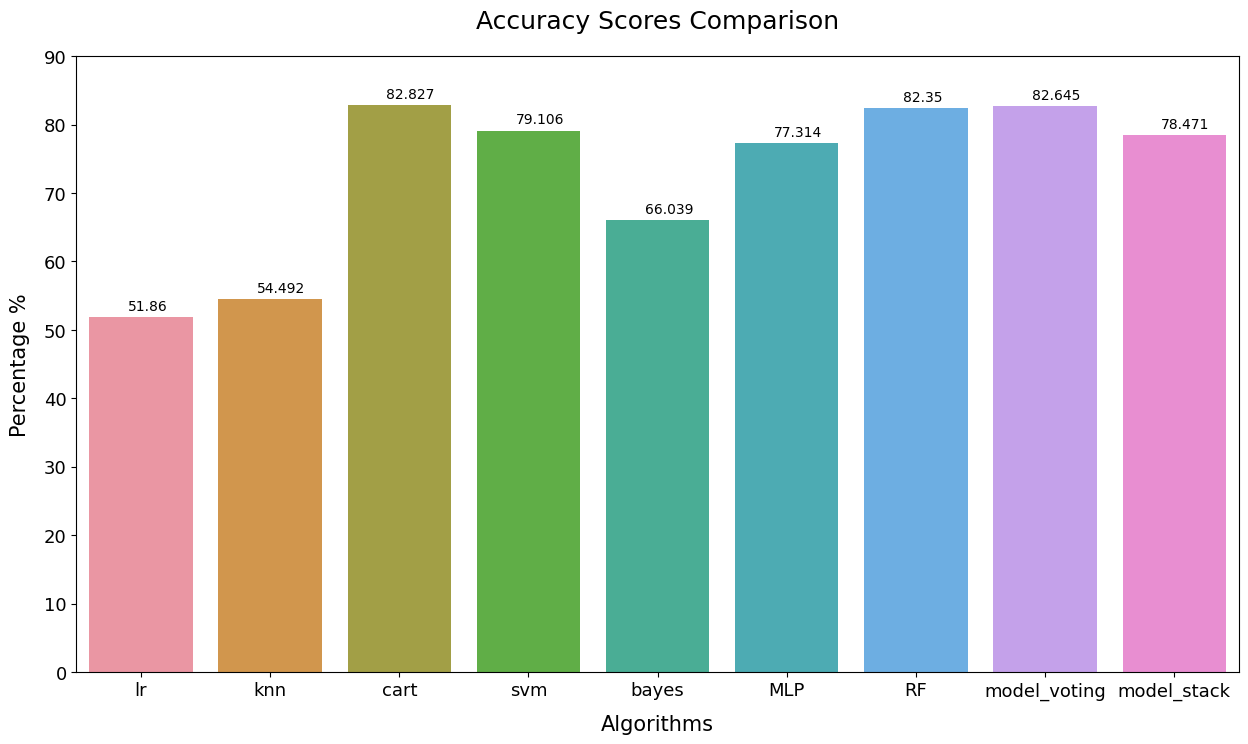

In [12]:
plt.figure(figsize=(15,8))
sns.set_palette('cividis')
ax=sns.barplot(x=list(accuracies.keys()),y=list(accuracies.values()))
plt.yticks(np.arange(0,100,10))
plt.ylabel('Percentage %',labelpad=10)
plt.xlabel('Algorithms',labelpad=10)
plt.title('Accuracy Scores Comparison',pad=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x()+0.3,p.get_height()+1.02))
plt.savefig("accuracy_scores_comparisonwsp2.png")
plt.show()

In [13]:
from sklearn.metrics import balanced_accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode y_test
y_test_encoded = label_encoder.fit_transform(y_test)

# Predictions
predictions = {
    'Gaussian Naive Bayes': bayes.predict(x_test),
    'Logistic Regression': lr.predict(x_test),
    'K-Nearest Neighbors': knn.predict(x_test),
    'Decision Tree': cart.predict(x_test),
    'Support Vector Machine': svm.predict(x_test),
    'Random Forest': RF.predict(x_test),
    'MLP (Multi-Layer Perceptron)': MLP.predict(x_test),
    'Voting Classifier': model_voting.predict(x_test),
    'Stacking Classifier': model_stack.predict(x_test)
}

# Metrics computation
metrics = {}
for name, pred in predictions.items():
    # Encode predictions to ensure consistency
    pred_encoded = label_encoder.transform(pred)
    
    f1 = f1_score(y_test_encoded, pred_encoded, average='weighted')
    recall = recall_score(y_test_encoded, pred_encoded, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test_encoded, pred_encoded)
    accuracy = accuracy_score(y_test_encoded, pred_encoded)
    precision = precision_score(y_test_encoded, pred_encoded, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, pred_encoded)
    class_report = classification_report(y_test_encoded, pred_encoded)
    
    metrics[name] = {
        'F1 Score': f1,
        'Recall': recall,
        'Balanced Accuracy': balanced_acc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report
    }

# Print or use the metrics as needed
for name, metric in metrics.items():
    print("Metrics for", name)
    for key, value in metric.items():
        print(key + ":")
        print(value)
        print("-------------------")


Metrics for Gaussian Naive Bayes
F1 Score:
0.47788185582427484
-------------------
Recall:
0.5186025408348457
-------------------
Balanced Accuracy:
0.6800901874907351
-------------------
Accuracy:
0.5186025408348457
-------------------
Precision:
0.5967060648571406
-------------------
Confusion Matrix:
[[16  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0 23]]
-------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       1.00      0.75      0.86         4
           2       0.48      0.73      0.58        15
           3       0.62      1.00      0.77         5
           4       0.71      1.00      0.83        10
           5       1.00      1.00      1.00         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        19
         

In [14]:
label_counts = df['llama2_labelone'].value_counts()
num_unique_labels = len(label_counts)
print("Number of unique labels:", num_unique_labels)


Number of unique labels: 301


In [15]:
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Calculate average and standard deviation of metrics
avg_f1 = np.mean(f1_scores, axis=0)
std_f1 = np.std(f1_scores, axis=0)

avg_recall = np.mean(recall_scores, axis=0)
std_recall = np.std(recall_scores, axis=0)

avg_balanced_accuracy = np.mean(balanced_accuracy_scores, axis=0)
std_balanced_accuracy = np.std(balanced_accuracy_scores, axis=0)

avg_accuracy = np.mean(accuracy_scores, axis=0)
std_accuracy = np.std(accuracy_scores, axis=0)

avg_precision = np.mean(precision_scores, axis=0)
std_precision = np.std(precision_scores, axis=0)

# Print or use the average and standard deviation of metrics
print("Average F1 Score (Standard Deviation):", avg_f1, "(", std_f1, ")")
print("Average Recall (Standard Deviation):", avg_recall, "(", std_recall, ")")
print("Average Balanced Accuracy (Standard Deviation):", avg_balanced_accuracy, "(", std_balanced_accuracy, ")")
print("Average Accuracy (Standard Deviation):", avg_accuracy, "(", std_accuracy, ")")
print("Average Precision (Standard Deviation):", avg_precision, "(", std_precision, ")")


Average F1 Score (Standard Deviation): [0.48102567 0.44333974 0.82624043 0.78906384 0.57904078 0.8216405
 0.76158737 0.82135045 0.77849704] ( [0.00607244 0.01141558 0.00907775 0.0059265  0.00723309 0.00657423
 0.0070971  0.00644586 0.00367743] )
Average Recall (Standard Deviation): [0.51933451 0.54439123 0.82495589 0.78931182 0.65888581 0.82288883
 0.77176708 0.82425006 0.78507688] ( [0.00427615 0.00961161 0.0094731  0.00690054 0.00596828 0.0069468
 0.00619439 0.00697746 0.00463607] )
Average Balanced Accuracy (Standard Deviation): [0.67760521 0.29121451 0.85901035 0.80915572 0.45618314 0.83687254
 0.75573956 0.83154982 0.78545811] ( [0.00722515 0.00299699 0.00762975 0.00362047 0.00573891 0.00739286
 0.0052915  0.00548253 0.00871747] )
Average Accuracy (Standard Deviation): [0.51933451 0.54439123 0.82495589 0.78931182 0.65888581 0.82288883
 0.77176708 0.82425006 0.78507688] ( [0.00427615 0.00961161 0.0094731  0.00690054 0.00596828 0.0069468
 0.00619439 0.00697746 0.00463607] )
Average 

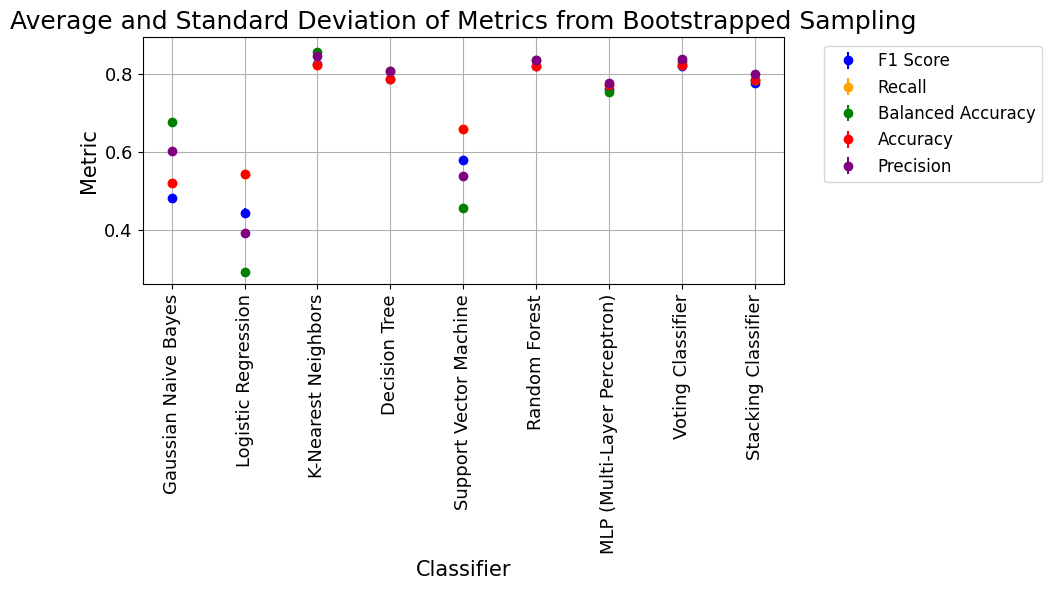

In [16]:
import matplotlib.pyplot as plt

# Define the classifiers
classifiers = list(predictions.keys())

# Plotting
plt.figure(figsize=(10, 6))

# Plot F1 Score
plt.errorbar(classifiers, avg_f1, yerr=std_f1, fmt='o', label='F1 Score', color='blue')

# Plot Recall
plt.errorbar(classifiers, avg_recall, yerr=std_recall, fmt='o', label='Recall', color='orange')

# Plot Balanced Accuracy
plt.errorbar(classifiers, avg_balanced_accuracy, yerr=std_balanced_accuracy, fmt='o', label='Balanced Accuracy', color='green')

# Plot Accuracy
plt.errorbar(classifiers, avg_accuracy, yerr=std_accuracy, fmt='o', label='Accuracy', color='red')

# Plot Precision
plt.errorbar(classifiers, avg_precision, yerr=std_precision, fmt='o', label='Precision', color='purple')

plt.xlabel('Classifier')
plt.ylabel('Metric')
plt.title('Average and Standard Deviation of Metrics from Bootstrapped Sampling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


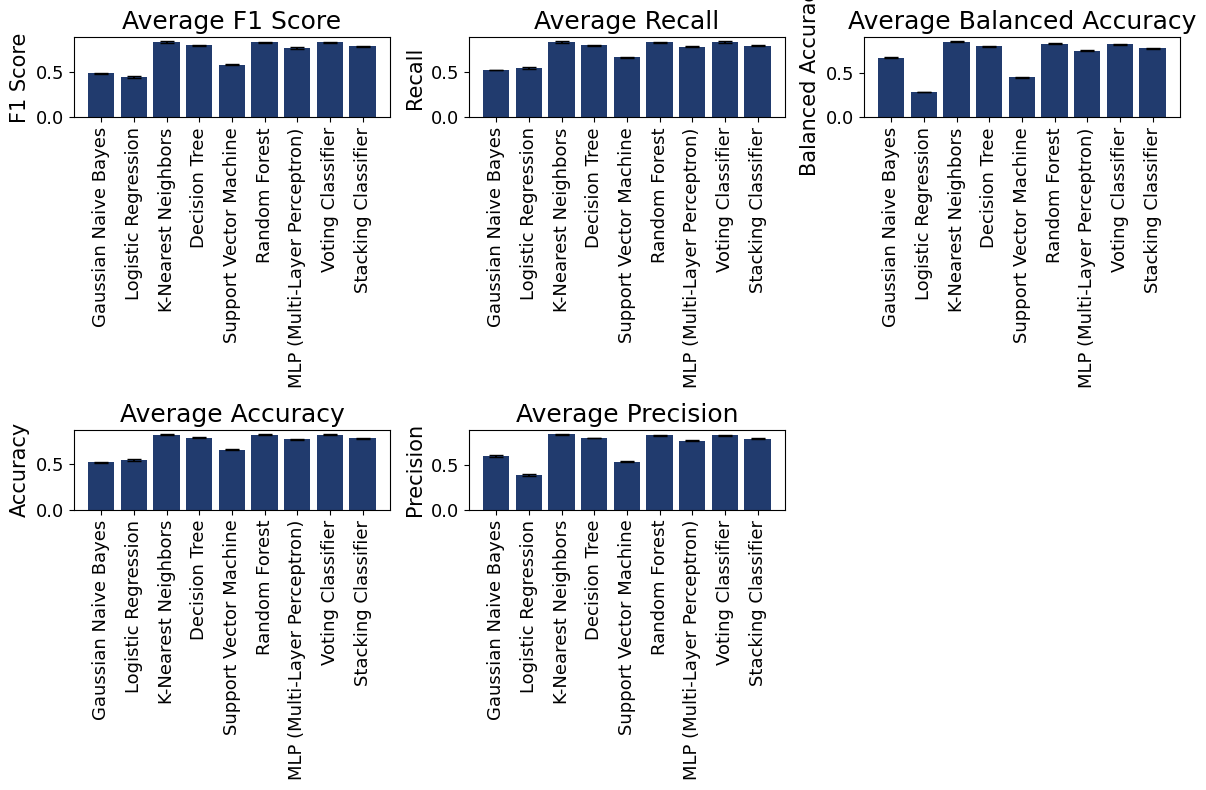

In [17]:
import matplotlib.pyplot as plt

# Define the classifiers
classifiers = list(predictions.keys())

# Plot metrics
plt.figure(figsize=(12, 8))

# F1 Score
plt.subplot(2, 3, 1)
plt.bar(classifiers, avg_f1, yerr=std_f1, capsize=5)
plt.title('Average F1 Score')
plt.xticks(rotation=90)
plt.ylabel('F1 Score')

# Recall
plt.subplot(2, 3, 2)
plt.bar(classifiers, avg_recall, yerr=std_recall, capsize=5)
plt.title('Average Recall')
plt.xticks(rotation=90)
plt.ylabel('Recall')

# Balanced Accuracy
plt.subplot(2, 3, 3)
plt.bar(classifiers, avg_balanced_accuracy, yerr=std_balanced_accuracy, capsize=5)
plt.title('Average Balanced Accuracy')
plt.xticks(rotation=90)
plt.ylabel('Balanced Accuracy')

# Accuracy
plt.subplot(2, 3, 4)
plt.bar(classifiers, avg_accuracy, yerr=std_accuracy, capsize=5)
plt.title('Average Accuracy')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

# Precision
plt.subplot(2, 3, 5)
plt.bar(classifiers, avg_precision, yerr=std_precision, capsize=5)
plt.title('Average Precision')
plt.xticks(rotation=90)
plt.ylabel('Precision')

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Calculate average and standard deviation of metrics
avg_f1 = np.mean(f1_scores, axis=0)
std_f1 = np.std(f1_scores, axis=0)

avg_recall = np.mean(recall_scores, axis=0)
std_recall = np.std(recall_scores, axis=0)

avg_balanced_accuracy = np.mean(balanced_accuracy_scores, axis=0)
std_balanced_accuracy = np.std(balanced_accuracy_scores, axis=0)

avg_accuracy = np.mean(accuracy_scores, axis=0)
std_accuracy = np.std(accuracy_scores, axis=0)

avg_precision = np.mean(precision_scores, axis=0)
std_precision = np.std(precision_scores, axis=0)

# Calculate lower and upper percentiles for each metric
percentile_lower = 2.5
percentile_upper = 97.5

ci_lower_f1 = np.percentile(f1_scores, percentile_lower, axis=0)
ci_upper_f1 = np.percentile(f1_scores, percentile_upper, axis=0)

ci_lower_recall = np.percentile(recall_scores, percentile_lower, axis=0)
ci_upper_recall = np.percentile(recall_scores, percentile_upper, axis=0)

ci_lower_balanced_accuracy = np.percentile(balanced_accuracy_scores, percentile_lower, axis=0)
ci_upper_balanced_accuracy = np.percentile(balanced_accuracy_scores, percentile_upper, axis=0)

ci_lower_accuracy = np.percentile(accuracy_scores, percentile_lower, axis=0)
ci_upper_accuracy = np.percentile(accuracy_scores, percentile_upper, axis=0)

ci_lower_precision = np.percentile(precision_scores, percentile_lower, axis=0)
ci_upper_precision = np.percentile(precision_scores, percentile_upper, axis=0)

# Print or use the average and standard deviation of metrics
print("Average F1 Score (Standard Deviation):", avg_f1, "(", std_f1, ")")
print("Average Recall (Standard Deviation):", avg_recall, "(", std_recall, ")")
print("Average Balanced Accuracy (Standard Deviation):", avg_balanced_accuracy, "(", std_balanced_accuracy, ")")
print("Average Accuracy (Standard Deviation):", avg_accuracy, "(", std_accuracy, ")")
print("Average Precision (Standard Deviation):", avg_precision, "(", std_precision, ")")

# Print or use the lower and upper percentiles of metrics
print("F1 Score 95% CI (Lower, Upper):", ci_lower_f1, ci_upper_f1)
print("Recall 95% CI (Lower, Upper):", ci_lower_recall, ci_upper_recall)
print("Balanced Accuracy 95% CI (Lower, Upper):", ci_lower_balanced_accuracy, ci_upper_balanced_accuracy)
print("Accuracy 95% CI (Lower, Upper):", ci_lower_accuracy, ci_upper_accuracy)
print("Precision 95% CI (Lower, Upper):", ci_lower_precision, ci_upper_precision)


Average F1 Score (Standard Deviation): [0.47963827 0.43678312 0.82475292 0.78945572 0.57784421 0.81806009
 0.76132991 0.81975989 0.77665557] ( [0.00702577 0.00935033 0.00584041 0.00581687 0.01175744 0.00315564
 0.0056821  0.00554622 0.00382062] )
Average Recall (Standard Deviation): [0.5180237  0.53834132 0.82394757 0.78820267 0.65757499 0.81880514
 0.77201916 0.82213259 0.78154777] ( [0.00307909 0.00798038 0.00588507 0.0051523  0.00985835 0.002777
 0.00508327 0.00449975 0.00164606] )
Average Balanced Accuracy (Standard Deviation): [0.68314817 0.29480645 0.85708278 0.80835882 0.46486833 0.83863057
 0.75833408 0.82918775 0.78599261] ( [0.00842193 0.00545328 0.00534938 0.01030818 0.00542595 0.00962394
 0.00891946 0.00677508 0.00369985] )
Average Accuracy (Standard Deviation): [0.5180237  0.53834132 0.82394757 0.78820267 0.65757499 0.81880514
 0.77201916 0.82213259 0.78154777] ( [0.00307909 0.00798038 0.00588507 0.0051523  0.00985835 0.002777
 0.00508327 0.00449975 0.00164606] )
Average P

In [19]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Create DataFrames for the results
results_f1 = pd.DataFrame(f1_scores, columns=predictions_sampled.keys())
results_recall = pd.DataFrame(recall_scores, columns=predictions_sampled.keys())
results_balanced_accuracy = pd.DataFrame(balanced_accuracy_scores, columns=predictions_sampled.keys())
results_accuracy = pd.DataFrame(accuracy_scores, columns=predictions_sampled.keys())
results_precision = pd.DataFrame(precision_scores, columns=predictions_sampled.keys())

# Calculate standard deviations of metrics
std_f1 = results_f1.std()
std_recall = results_recall.std()
std_balanced_accuracy = results_balanced_accuracy.std()
std_accuracy = results_accuracy.std()
std_precision = results_precision.std()

# Calculate percentiles of metrics
percentiles = [2.5, 97.5]
percentile_values_f1 = results_f1.quantile(q=np.array(percentiles) / 100)
percentile_values_recall = results_recall.quantile(q=np.array(percentiles) / 100)
percentile_values_balanced_accuracy = results_balanced_accuracy.quantile(q=np.array(percentiles) / 100)
percentile_values_accuracy = results_accuracy.quantile(q=np.array(percentiles) / 100)
percentile_values_precision = results_precision.quantile(q=np.array(percentiles) / 100)

# Create DataFrames for standard deviations and percentiles
results_std = pd.DataFrame({'F1 Score': std_f1, 'Recall': std_recall, 'Balanced Accuracy': std_balanced_accuracy, 'Accuracy': std_accuracy, 'Precision': std_precision})
results_percentiles = pd.concat([percentile_values_f1, percentile_values_recall, percentile_values_balanced_accuracy, percentile_values_accuracy, percentile_values_precision], keys=['F1 Score', 'Recall', 'Balanced Accuracy', 'Accuracy', 'Precision'], axis=1)

# Print or use the DataFrames for the results
print("Standard Deviations:")
print(results_std)
print("\nPercentiles:")
print(results_percentiles)


Standard Deviations:
                              F1 Score    Recall  Balanced Accuracy  Accuracy  \
Gaussian Naive Bayes          0.009010  0.008804           0.006787  0.008804   
Logistic Regression           0.003645  0.004588           0.006493  0.004588   
K-Nearest Neighbors           0.006778  0.005935           0.009945  0.005935   
Decision Tree                 0.005793  0.005089           0.007484  0.005089   
Support Vector Machine        0.009909  0.008814           0.007535  0.008814   
Random Forest                 0.005446  0.004354           0.006743  0.004354   
MLP (Multi-Layer Perceptron)  0.004889  0.003928           0.003878  0.003928   
Voting Classifier             0.004548  0.004159           0.007501  0.004159   
Stacking Classifier           0.006575  0.006630           0.004241  0.006630   

                              Precision  
Gaussian Naive Bayes           0.015968  
Logistic Regression            0.003232  
K-Nearest Neighbors            0.006897  


<Figure size 1000x600 with 0 Axes>

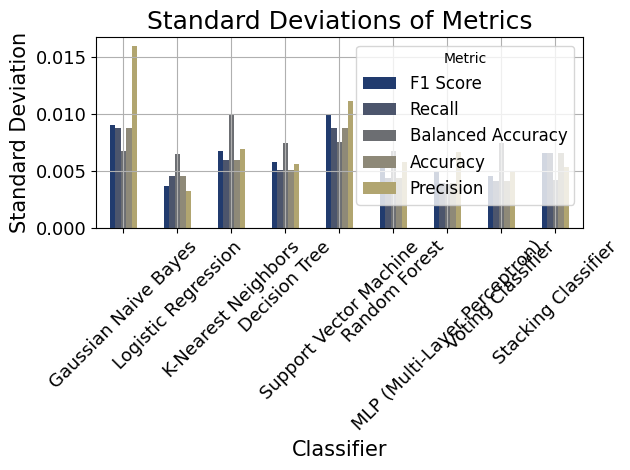

In [20]:
import matplotlib.pyplot as plt

# Plotting standard deviations
plt.figure(figsize=(10, 6))
results_std.plot(kind='bar', rot=45)
plt.title('Standard Deviations of Metrics')
plt.xlabel('Classifier')
plt.ylabel('Standard Deviation')
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()



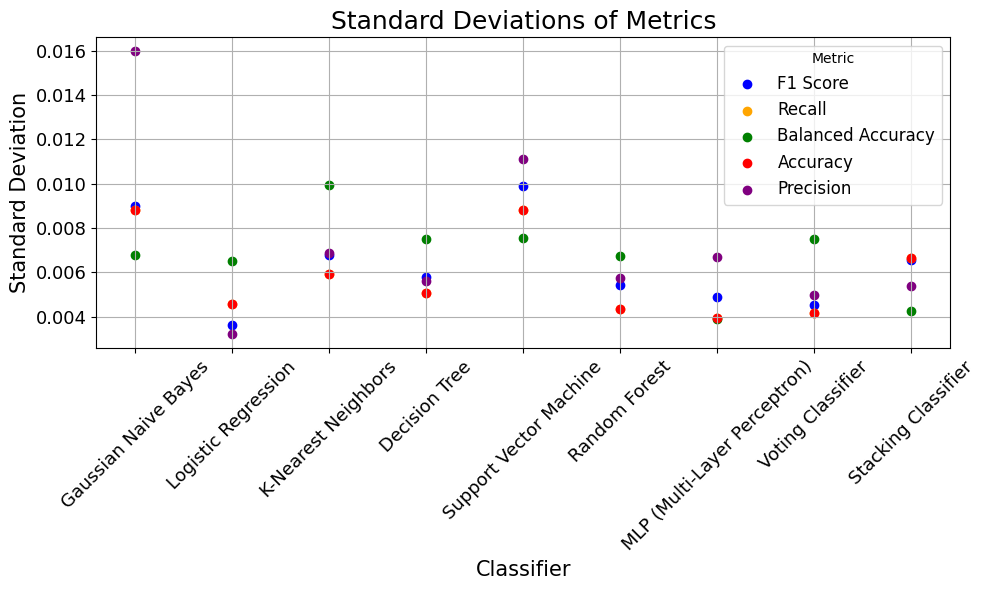

In [21]:
import matplotlib.pyplot as plt

# Define colors for each metric
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plotting standard deviations
plt.figure(figsize=(10, 6))
for i, metric in enumerate(results_std.columns):
    if i < len(colors):
        plt.scatter(results_std.index, results_std[metric], color=colors[i], label=metric)
    else:
        plt.scatter(results_std.index, results_std[metric], label=metric)
plt.title('Standard Deviations of Metrics')
plt.xlabel('Classifier')
plt.ylabel('Standard Deviation')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [22]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score

# Initialize an empty list to store dictionaries of metrics
results_list = []

# Loop through each classifier and its corresponding metrics
for name, metric in metrics.items():
    # Encode predictions to ensure consistency
    pred_encoded = label_encoder.transform(predictions[name])
    
    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test_encoded, pred_encoded)
    
    # Append the metrics to the list
    results_list.append({
        'Classifier': name,
        'F1 Score': metric['F1 Score'],
        'Recall': metric['Recall'],
        'Balanced Accuracy': balanced_acc,
        'Accuracy': metric['Accuracy'],
        'Precision': metric['Precision'],
        'Confusion Matrix': metric['Confusion Matrix'],
        'Classification Report': metric['Classification Report']
    })

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_list)

# Print the DataFrame
# print(results_df)
results_df


,Classifier,F1 Score,Recall,Balanced Accuracy,Accuracy,Precision,Confusion Matrix,Classification Report
0,Gaussian Naive Bayes,0.477882,0.518603,0.680090,0.518603,0.596706,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
1,Logistic Regression,0.443350,0.544918,0.292926,0.544918,0.390569,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",precision recall f1-score ...
2,K-Nearest Neighbors,0.828729,0.828267,0.857649,0.828267,0.843437,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
3,Decision Tree,0.791106,0.791062,0.807399,0.791062,0.804977,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
4,Support Vector Machine,0.581080,0.660390,0.458619,0.660390,0.542158,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
5,Random Forest,0.822211,0.823503,0.837182,0.823503,0.833459,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
6,MLP (Multi-Layer Perceptron),0.761934,0.773140,0.756216,0.773140,0.773340,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
7,Voting Classifier,0.823672,0.826452,0.829412,0.826452,0.835923,"[[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...
8,Stacking Classifier,0.778596,0.784710,0.785461,0.784710,0.795142,"[[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",precision recall f1-score ...


In [23]:
# Convert standard deviations to percentages for each classifier
results_std_percentage = results_std.apply(lambda x: x * 100)

# Print or use the DataFrame with percentages
print("Standard Deviations as Percentages:")
print(results_std_percentage)


Standard Deviations as Percentages:
                              F1 Score    Recall  Balanced Accuracy  Accuracy  \
Gaussian Naive Bayes          0.900997  0.880404           0.678706  0.880404   
Logistic Regression           0.364523  0.458827           0.649336  0.458827   
K-Nearest Neighbors           0.677846  0.593486           0.994511  0.593486   
Decision Tree                 0.579254  0.508864           0.748417  0.508864   
Support Vector Machine        0.990892  0.881378           0.753459  0.881378   
Random Forest                 0.544560  0.435376           0.674261  0.435376   
MLP (Multi-Layer Perceptron)  0.488941  0.392792           0.387786  0.392792   
Voting Classifier             0.454770  0.415893           0.750114  0.415893   
Stacking Classifier           0.657501  0.662974           0.424103  0.662974   

                              Precision  
Gaussian Naive Bayes           1.596766  
Logistic Regression            0.323155  
K-Nearest Neighbors        

In [25]:
df.columns

Index(['Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype', 'alltext',
       'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate', 'Text_langue2',
       'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat', 'Text_spell',
       'Text_langue3', 'Text_translate2', 'Text_token', 'Text_stop',
       'Text_stem', 'Text_lemma', 'berttopic2', 'cluster_id2',
       'llama2_labelone10', 'cluster_labelone10', 'cluster_id',
       'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [26]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Convert 'label_llama2' column to a list
topics_list = df['cluster_labelone'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)

# Compute coherence score using CoherenceModel (C_v)
coherence_model_cv = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_cv_score = coherence_model_cv.get_coherence()

# Compute coherence score using CoherenceModel (NPMI)
coherence_model_npmi = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_npmi')
coherence_npmi_score = coherence_model_npmi.get_coherence()

# Compute coherence score using CoherenceModel (Umass)
coherence_model_umass = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='u_mass')
coherence_umass_score = coherence_model_umass.get_coherence()

# Save results to a text file
output_file = "coherence_scores_gensimwsp2.txt"
with open(output_file, "w") as file:
    file.write("Coherence Score_wordwsp1 (CV): {}\n".format(coherence_cv_score))
    file.write("Coherence Score_wordwsp1 (NPMI): {}\n".format(coherence_npmi_score))
    file.write("Coherence Score_wordwsp1 (Umass): {}\n".format(coherence_umass_score))

# print("Results saved to:", output_file)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [27]:
print("Coherence Score_llama (NPMI):", coherence_npmi_score)

Coherence Score_llama (NPMI): 0.29658696819288344


In [28]:

print("Coherence Score_llama (CV):", coherence_cv_score)

Coherence Score_llama (CV): 0.8123069887474059


In [29]:

print("Coherence Score_llama (Umass):", coherence_umass_score)

Coherence Score_llama (Umass): -1.8358285202588511


In [30]:
# from contextualized_topic_models.evaluation.measures import InvertedRBO
# from gensim.corpora.dictionary import Dictionary

# # Convert 'label_llama2' column to a list
# topics_list = df['llama2_labelone'].tolist()

# # Convert documents to a list of tokenized documents
# documents = df['Text_lemma'].tolist()
# documents = [doc.split() for doc in documents]

# # Convert documents to a Gensim dictionary
# dictionary = Dictionary(documents)
# irbo_ctm = InvertedRBO(topics=topics_list)
# print("coherence score IRBO:", irbo_ctm.score())

In [31]:
df.columns

Index(['Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype', 'alltext',
       'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate', 'Text_langue2',
       'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat', 'Text_spell',
       'Text_langue3', 'Text_translate2', 'Text_token', 'Text_stop',
       'Text_stem', 'Text_lemma', 'berttopic2', 'cluster_id2',
       'llama2_labelone10', 'cluster_labelone10', 'cluster_id',
       'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [32]:
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora.dictionary import Dictionary

# # Convert 'label_llama2' column to a list
# topics_list = df['llama2_labelone'].tolist()

# # Convert documents to a list of tokenized documents
# documents = df['Text_lemma'].tolist()
# documents = [doc.split() for doc in documents]

# # Convert documents to a Gensim dictionary
# dictionary = Dictionary(documents)

# # Compute coherence score using CoherenceModel (C_v)
# coherence_model_cv = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_v')
# coherence_cv_score = coherence_model_cv.get_coherence()

# # Compute coherence score using CoherenceModel (NPMI)
# coherence_model_npmi = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_npmi')
# coherence_npmi_score = coherence_model_npmi.get_coherence()

# # Compute coherence score using CoherenceModel (Umass)
# coherence_model_umass = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='u_mass')
# coherence_umass_score = coherence_model_umass.get_coherence()

# # # Save results to a text file
# # output_file = "coherence_scores_gensimwsp2.txt"
# # with open(output_file, "w") as file:
# #     file.write("Coherence Score_wordwsp1 (CV): {}\n".format(coherence_cv_score))
# #     file.write("Coherence Score_wordwsp1 (NPMI): {}\n".format(coherence_npmi_score))
# #     file.write("Coherence Score_wordwsp1 (Umass): {}\n".format(coherence_umass_score))

# # print("Results saved to:", output_file)
# print("Coherence Score_llama (NPMI):", coherence_npmi_score)
# print("Coherence Score_llama (CV):", coherence_cv_score)
# print("Coherence Score_llama (Umass):", coherence_umass_score)

In [ ]:
from contextualized_topic_models.evaluation.measures import InvertedRBO
from gensim.corpora.dictionary import Dictionary

# Convert 'label_llama2' column to a list
topics_list = df['llama2_labelone'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)
irbo_ctm = InvertedRBO(topics=topics_list)
print("coherence score IRBO:", irbo_ctm.score())

In [ ]:
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

# Calculate silhouette score
silhouette_avg = silhouette_score(X_embedded, df['llama2_labelone'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Calinski-Harabasz index
calinski_harabasz_avg = calinski_harabasz_score(X_embedded, df['llama2_labelone'])
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")

# Calculate Davies-Bouldin index
davies_bouldin_avg = davies_bouldin_score(X_embedded, df['llama2_labelone'])
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# Save results to a text file
output_file = "clustering_metricswsp2.txt"
with open(output_file, "a") as file:
    file.write("Silhouette Score: {}\n".format(silhouette_avg))
    file.write("Calinski-Harabasz Index: {}\n".format(calinski_harabasz_avg))
    file.write("Davies-Bouldin Index: {}\n".format(davies_bouldin_avg))

# print("Results saved to:", output_file)


In [ ]:
df.shape

In [ ]:
df.shape

In [34]:
# df['llama2_labelone10']=df[['llama2_labelswsp']]
df.columns

Index(['Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype', 'alltext',
       'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate', 'Text_langue2',
       'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat', 'Text_spell',
       'Text_langue3', 'Text_translate2', 'Text_token', 'Text_stop',
       'Text_stem', 'Text_lemma', 'berttopic2', 'cluster_id2',
       'llama2_labelone10', 'cluster_labelone10', 'cluster_id',
       'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [44]:

from sklearn import model_selection 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import urllib
from sklearn import neighbors
import warnings
warnings.filterwarnings('ignore')
#------------------------------------Metrics and Validation---------------------------------------------------------#
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
#-------------------------------------Models to be trained----------------------------------------------------------#
from sklearn.ensemble import StackingClassifier, VotingClassifier
import xgboost
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('figure', titlesize=35)
plt.rc('legend', fontsize=12)
avg_accuracies={}
accuracies={}
roc_auc={}
pr_auc={}
def conf_matrix(ytest,pred):
    plt.figure(figsize=(9,6))
    global cm1
    cm1 = confusion_matrix(ytest, pred)
    ax=sns.heatmap(cm1, annot= True, cmap='Blues')
    plt.title('Confusion Matrix',pad=20)
def metrics_score(cm):
    total=sum(sum(cm))
    accuracy=(cm[0,0]+cm[1,1])/total
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    specificity = cm[0,0]/(cm[0,1]+cm[0,0])
    values=[np.round(accuracy*100,3),np.round(precision*100,3),np.round(sensitivity*100,3),np.round(f1*100,3),np.round(specificity*100,3)]
    plt.figure(figsize=(15,8))
    sns.set_palette('magma')
    ax=sns.barplot(x=['Accuracy','Precision','Recall','F1 score','Specificity'],y=values)
    plt.yticks(np.arange(0,100,10))
    plt.ylabel('Percentage %',labelpad=10)
    plt.xlabel('Scoring Parameter',labelpad=10)
    plt.title('Metrics Scores',pad=20)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x()+0.3,p.get_height()+1.02))
    plt.show()
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='Orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.ylabel('True Positive Rate',labelpad=10)
    plt.xlabel('False Positive Rate',labelpad=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve',pad=20)
    plt.legend()
    plt.show()
def plot_precision_recall_curve(recall, precision):
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='orange', label='PRC')
    plt.ylabel('Precision',labelpad=10)
    plt.xlabel('Recall',labelpad=10)
    plt.title('Precision Recall Curve',pad=20)
    plt.legend()
    plt.show()
# Scaling X_embedded
X_embedded = preprocessing.scale(X_embedded)

# Defining target variable
y = df[['llama2_labelone10']].values

# Splitting the data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_embedded, y, test_size=0.2, random_state=42, stratify=y)

# Apply UMAP only on the training data
umap_transformer = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
x_train = umap_transformer.fit_transform(x_train)

# Transform the test data using the fitted UMAP transformer
x_test = umap_transformer.transform(x_test)




# get a list of models to evaluate
from sklearn.neural_network import MLPClassifier

def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['RF'] = RandomForestClassifier()
    models['bayes'] = GaussianNB()
    models['MLP']=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    
    return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# Define cross-validation strategy
# cv = StratifiedKFold(n_splits=p_cv, random_state=100, shuffle=True)
# cv = model_selection.StratifiedKFold(n_splits=p_cv, random_state=100, shuffle=True)
bayes=GaussianNB()
# bayes = GaussianNB(bayes, param_grid=None, cv=cv, scoring=p_score, n_jobs=-1, verbose=1)
bayes.fit(x_train, y_train)

lr=LogisticRegression()
lr.fit(x_train, y_train)

knn=KNeighborsClassifier()
knn.fit(x_train, y_train)

cart=DecisionTreeClassifier()
cart.fit(x_train, y_train)

svm=SVC(probability=True)
svm.fit(x_train, y_train)

RF=RandomForestClassifier()
RF.fit(x_train, y_train)
MLP=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
MLP.fit(x_train, y_train)

# from lightgbm import
prediction1 = bayes.predict(x_test)
accuracy1 = bayes.score(x_test, y_test) 

prediction2 = lr.predict(x_test)
accuracy2 = lr.score(x_test, y_test) 

prediction3 = knn.predict(x_test)
accuracy3 = knn.score(x_test, y_test) 

prediction4 = cart.predict(x_test)
accuracy4 = cart.score(x_test, y_test) 

prediction5 = svm.predict(x_test)
accuracy5 = svm.score(x_test, y_test) 

prediction6 = MLP.predict(x_test)
accuracy6 = MLP.score(x_test, y_test) 

prediction7 = RF.predict(x_test)
accuracy7 = RF.score(x_test, y_test) 
estimators = [
    ('lr', lr),
    ('knn', knn),
    ('cart', cart),
    ('svm', svm),
    ('RF', RF),
    ('bayes', bayes),
    ('MLP', MLP)
]

# estimators

model_voting = VotingClassifier(
    estimators = estimators,
    voting='soft', 
    n_jobs=-1,
    flatten_transform=True, 
    verbose=1).fit(x_train, y_train)

model_voting.score(x_train, y_train)
prediction8=model_voting.predict(x_test)
accuracy8 = model_voting.score(x_test, y_test)
print(classification_report(y_test, prediction8))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

                                                                                                                                 precision    recall  f1-score   support

                                                             "African countries' COVID-19 travel restrictions and requirements"       0.95      0.98      0.96      3326
                                                        "China's Rise in Global Politics: Prosperity, Influence, and Reactions"       1.00      0.92      0.96        24
                                                          "Entrepreneurial Innovation in Energy & Environmental Sustainability"       0.89      0.45      0.60       140
                                                                 "Nicki Minaj Reactions at Davos and Biden's Daily Documentary"       0.95      0.67      0.79        61
                                    "Pitbulls in Washington: Shouting Match between Schumer, Pelosi, Alicia Había, and Comptes"       0.92      0.61      

In [45]:
# df.columns

In [46]:
accuracies['lr'] = np.round(accuracy1 * 100,3)

accuracies['knn'] = np.round(accuracy2 * 100,3)

accuracies['cart'] = np.round(accuracy3 * 100,3)

accuracies['svm'] = np.round(accuracy4 * 100,3)

accuracies['bayes'] = np.round(accuracy5 * 100,3)

accuracies['MLP'] = np.round(accuracy6 * 100,3)
accuracies['RF'] = np.round(accuracy7 * 100,3)
accuracies['model_voting'] = np.round(accuracy8 * 100,3)

In [47]:
xgc = xgboost.XGBClassifier()

model_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=xgc,
    n_jobs = -1,
    verbose = 1
)

model_stack.fit(x_train, y_train)

model_stack.score(x_train, y_train)

/home/hsibitenda/anaconda3/envs/harriet_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBacke

0.9717494894486045

In [48]:
prediction9=model_stack.predict(x_test)
accuracy9 = model_stack.score(x_test, y_test)
print(classification_report(y_test, prediction9))

                                                                                                                                 precision    recall  f1-score   support

                                                             "African countries' COVID-19 travel restrictions and requirements"       0.97      0.97      0.97      3326
                                                        "China's Rise in Global Politics: Prosperity, Influence, and Reactions"       1.00      0.92      0.96        24
                                                          "Entrepreneurial Innovation in Energy & Environmental Sustainability"       0.85      0.76      0.80       140
                                                                 "Nicki Minaj Reactions at Davos and Biden's Daily Documentary"       0.96      0.75      0.84        61
                                    "Pitbulls in Washington: Shouting Match between Schumer, Pelosi, Alicia Había, and Comptes"       0.80      0.89      

In [49]:
# print(classification_report(y_test, prediction8))

In [50]:

accuracies['model_stack'] = np.round(accuracy8 * 100,3)

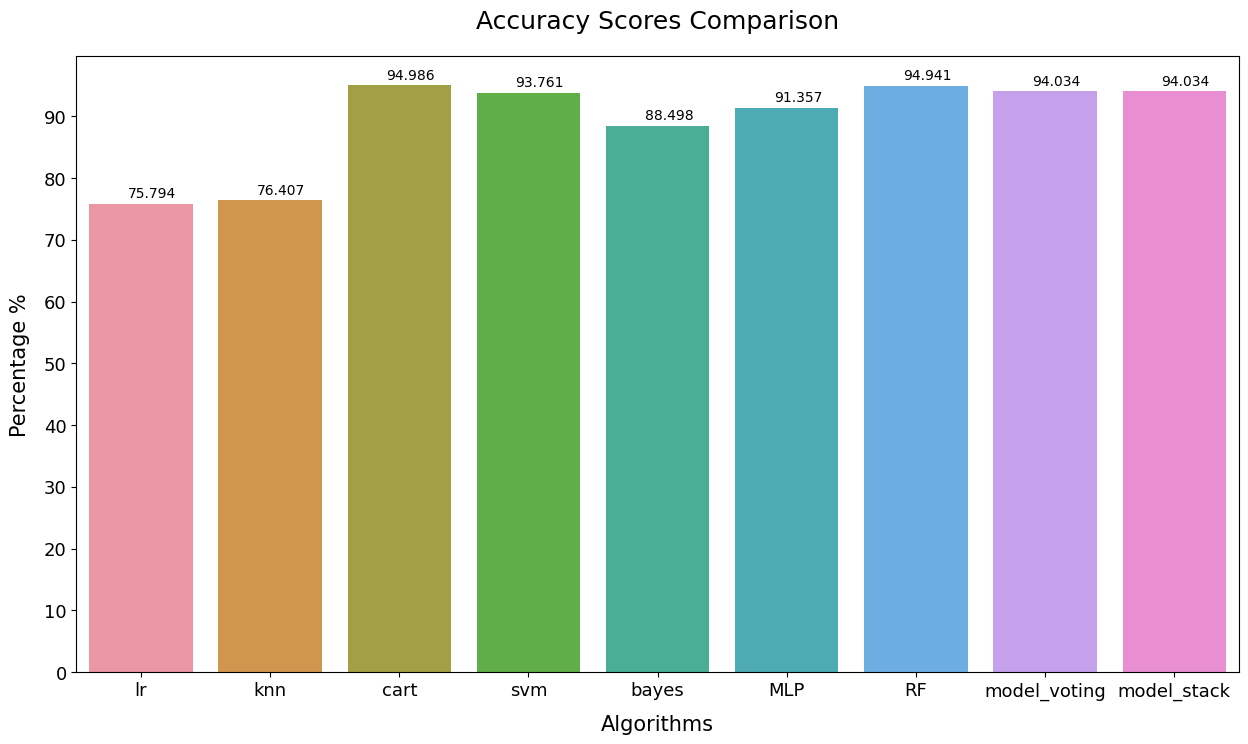

In [51]:
plt.figure(figsize=(15,8))
sns.set_palette('cividis')
ax=sns.barplot(x=list(accuracies.keys()),y=list(accuracies.values()))
plt.yticks(np.arange(0,100,10))
plt.ylabel('Percentage %',labelpad=10)
plt.xlabel('Algorithms',labelpad=10)
plt.title('Accuracy Scores Comparison',pad=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x()+0.3,p.get_height()+1.02))
plt.savefig("accuracy_scores_comparisonwsp2.png")
plt.show()

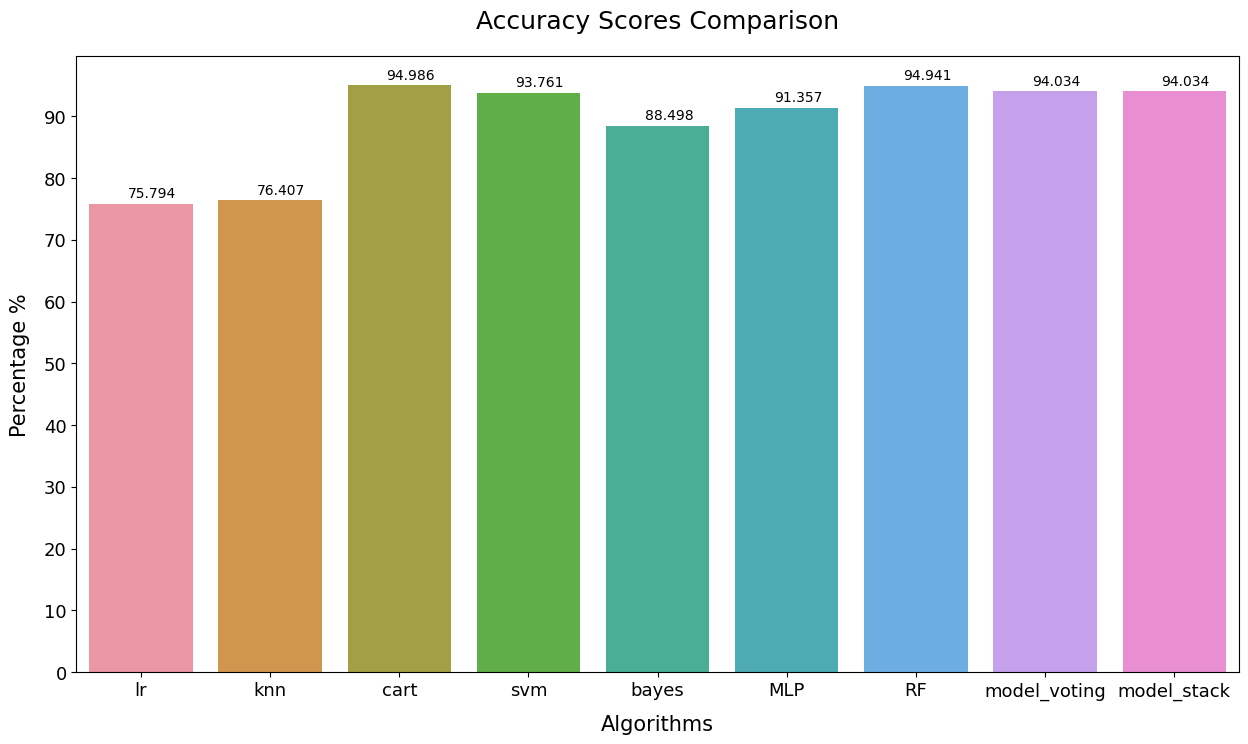

In [52]:
plt.figure(figsize=(15,8))
sns.set_palette('cividis')
ax=sns.barplot(x=list(accuracies.keys()),y=list(accuracies.values()))
plt.yticks(np.arange(0,100,10))
plt.ylabel('Percentage %',labelpad=10)
plt.xlabel('Algorithms',labelpad=10)
plt.title('Accuracy Scores Comparison',pad=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x()+0.3,p.get_height()+1.02))
plt.savefig("accuracy_scores_comparisonwsp2.png")
plt.show()

In [53]:
from sklearn.metrics import balanced_accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode y_test
y_test_encoded = label_encoder.fit_transform(y_test)

# Predictions
predictions = {
    'Gaussian Naive Bayes': bayes.predict(x_test),
    'Logistic Regression': lr.predict(x_test),
    'K-Nearest Neighbors': knn.predict(x_test),
    'Decision Tree': cart.predict(x_test),
    'Support Vector Machine': svm.predict(x_test),
    'Random Forest': RF.predict(x_test),
    'MLP (Multi-Layer Perceptron)': MLP.predict(x_test),
    'Voting Classifier': model_voting.predict(x_test),
    'Stacking Classifier': model_stack.predict(x_test)
}

# Metrics computation
metrics = {}
for name, pred in predictions.items():
    # Encode predictions to ensure consistency
    pred_encoded = label_encoder.transform(pred)
    
    f1 = f1_score(y_test_encoded, pred_encoded, average='weighted')
    recall = recall_score(y_test_encoded, pred_encoded, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test_encoded, pred_encoded)
    accuracy = accuracy_score(y_test_encoded, pred_encoded)
    precision = precision_score(y_test_encoded, pred_encoded, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, pred_encoded)
    class_report = classification_report(y_test_encoded, pred_encoded)
    
    metrics[name] = {
        'F1 Score': f1,
        'Recall': recall,
        'Balanced Accuracy': balanced_acc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report
    }

# Print or use the metrics as needed
for name, metric in metrics.items():
    print("Metrics for", name)
    for key, value in metric.items():
        print(key + ":")
        print(value)
        print("-------------------")


Metrics for Gaussian Naive Bayes
F1 Score:
0.7417733549723394
-------------------
Recall:
0.757940108892922
-------------------
Balanced Accuracy:
0.24380976993198425
-------------------
Accuracy:
0.757940108892922
-------------------
Precision:
0.7485631368481568
-------------------
Confusion Matrix:
[[2824    2    0    0    0  474   15   11    0    0]
 [  15    4    0    0    0    5    0    0    0    0]
 [ 113    0    0    0    0   27    0    0    0    0]
 [  19    0    0    0    0   42    0    0    0    0]
 [  11    0    0    0    0    7    0    0    0    0]
 [ 121    0    0    0    0  475    0    4    0    0]
 [  14    0    0    0    0    4   29    4    0    0]
 [  36    9    0    0    0   91    0    9    0    0]
 [  10    0    0    0    0   18    0    0    0    0]
 [   3    3    0    0    0    9    0    0    0    0]]
-------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3326
           1  

In [54]:
label_counts = df['llama2_labelone10'].value_counts()
num_unique_labels = len(label_counts)
print("Number of unique labels:", num_unique_labels)


Number of unique labels: 10


In [55]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Calculate average and standard deviation of metrics
avg_f1 = np.mean(f1_scores, axis=0)
std_f1 = np.std(f1_scores, axis=0)

avg_recall = np.mean(recall_scores, axis=0)
std_recall = np.std(recall_scores, axis=0)

avg_balanced_accuracy = np.mean(balanced_accuracy_scores, axis=0)
std_balanced_accuracy = np.std(balanced_accuracy_scores, axis=0)

avg_accuracy = np.mean(accuracy_scores, axis=0)
std_accuracy = np.std(accuracy_scores, axis=0)

avg_precision = np.mean(precision_scores, axis=0)
std_precision = np.std(precision_scores, axis=0)

# Print or use the average and standard deviation of metrics
print("Average F1 Score (Standard Deviation):", avg_f1, "(", std_f1, ")")
print("Average Recall (Standard Deviation):", avg_recall, "(", std_recall, ")")
print("Average Balanced Accuracy (Standard Deviation):", avg_balanced_accuracy, "(", std_balanced_accuracy, ")")
print("Average Accuracy (Standard Deviation):", avg_accuracy, "(", std_accuracy, ")")
print("Average Precision (Standard Deviation):", avg_precision, "(", std_precision, ")")


Average F1 Score (Standard Deviation): [0.74214181 0.7005973  0.94712991 0.93513702 0.87146449 0.94711016
 0.90621789 0.93514159 0.9461227 ] ( [0.00481093 0.00787723 0.00223302 0.00278536 0.00312542 0.0018692
 0.00438594 0.00329881 0.00241191] )
Average Recall (Standard Deviation): [0.75971767 0.76264179 0.94681119 0.93501386 0.88389211 0.94721452
 0.91242753 0.93864381 0.94635745] ( [0.00279069 0.00529871 0.0022771  0.00285819 0.00268958 0.00186334
 0.00417144 0.00294664 0.00250258] )
Average Balanced Accuracy (Standard Deviation): [0.23820029 0.12385141 0.88537599 0.84158053 0.64532618 0.8902503
 0.7705326  0.80350925 0.88520043] ( [0.00720407 0.00322992 0.00695327 0.01120845 0.02308825 0.00673317
 0.00841898 0.01219328 0.00811818] )
Average Accuracy (Standard Deviation): [0.75971767 0.76264179 0.94681119 0.93501386 0.88389211 0.94721452
 0.91242753 0.93864381 0.94635745] ( [0.00279069 0.00529871 0.0022771  0.00285819 0.00268958 0.00186334
 0.00417144 0.00294664 0.00250258] )
Average

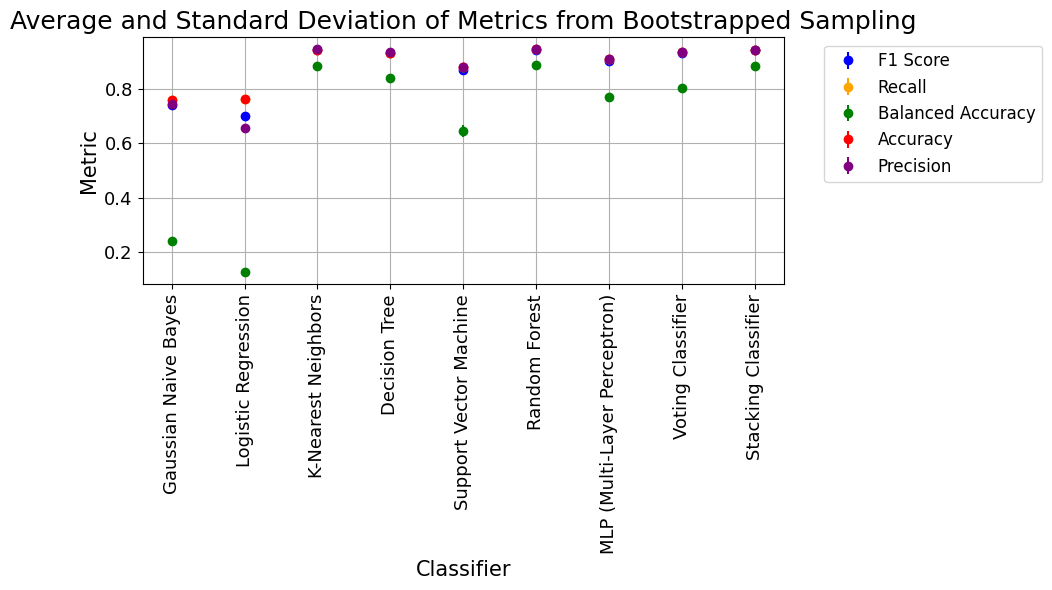

In [56]:
import matplotlib.pyplot as plt

# Define the classifiers
classifiers = list(predictions.keys())

# Plotting
plt.figure(figsize=(10, 6))

# Plot F1 Score
plt.errorbar(classifiers, avg_f1, yerr=std_f1, fmt='o', label='F1 Score', color='blue')

# Plot Recall
plt.errorbar(classifiers, avg_recall, yerr=std_recall, fmt='o', label='Recall', color='orange')

# Plot Balanced Accuracy
plt.errorbar(classifiers, avg_balanced_accuracy, yerr=std_balanced_accuracy, fmt='o', label='Balanced Accuracy', color='green')

# Plot Accuracy
plt.errorbar(classifiers, avg_accuracy, yerr=std_accuracy, fmt='o', label='Accuracy', color='red')

# Plot Precision
plt.errorbar(classifiers, avg_precision, yerr=std_precision, fmt='o', label='Precision', color='purple')

plt.xlabel('Classifier')
plt.ylabel('Metric')
plt.title('Average and Standard Deviation of Metrics from Bootstrapped Sampling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


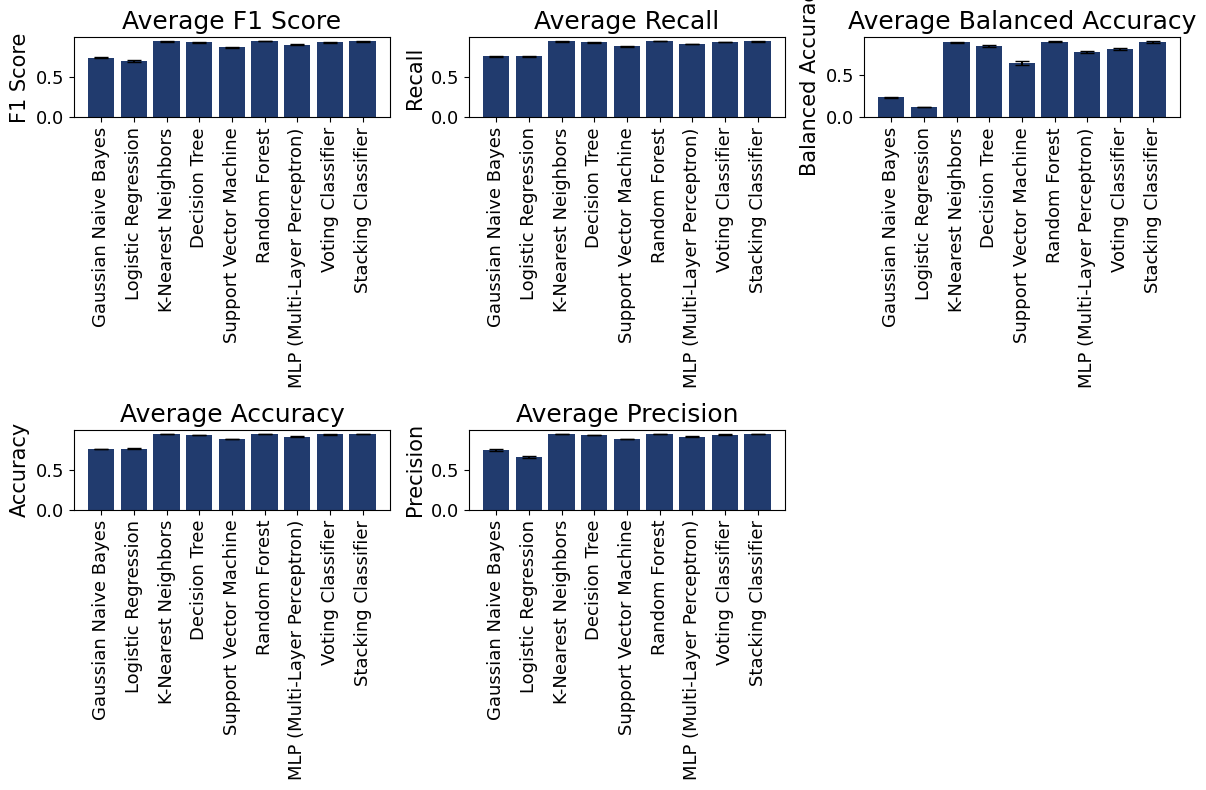

In [57]:
import matplotlib.pyplot as plt

# Define the classifiers
classifiers = list(predictions.keys())

# Plot metrics
plt.figure(figsize=(12, 8))

# F1 Score
plt.subplot(2, 3, 1)
plt.bar(classifiers, avg_f1, yerr=std_f1, capsize=5)
plt.title('Average F1 Score')
plt.xticks(rotation=90)
plt.ylabel('F1 Score')

# Recall
plt.subplot(2, 3, 2)
plt.bar(classifiers, avg_recall, yerr=std_recall, capsize=5)
plt.title('Average Recall')
plt.xticks(rotation=90)
plt.ylabel('Recall')

# Balanced Accuracy
plt.subplot(2, 3, 3)
plt.bar(classifiers, avg_balanced_accuracy, yerr=std_balanced_accuracy, capsize=5)
plt.title('Average Balanced Accuracy')
plt.xticks(rotation=90)
plt.ylabel('Balanced Accuracy')

# Accuracy
plt.subplot(2, 3, 4)
plt.bar(classifiers, avg_accuracy, yerr=std_accuracy, capsize=5)
plt.title('Average Accuracy')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

# Precision
plt.subplot(2, 3, 5)
plt.bar(classifiers, avg_precision, yerr=std_precision, capsize=5)
plt.title('Average Precision')
plt.xticks(rotation=90)
plt.ylabel('Precision')

plt.tight_layout()
plt.show()


In [58]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Calculate average and standard deviation of metrics
avg_f1 = np.mean(f1_scores, axis=0)
std_f1 = np.std(f1_scores, axis=0)

avg_recall = np.mean(recall_scores, axis=0)
std_recall = np.std(recall_scores, axis=0)

avg_balanced_accuracy = np.mean(balanced_accuracy_scores, axis=0)
std_balanced_accuracy = np.std(balanced_accuracy_scores, axis=0)

avg_accuracy = np.mean(accuracy_scores, axis=0)
std_accuracy = np.std(accuracy_scores, axis=0)

avg_precision = np.mean(precision_scores, axis=0)
std_precision = np.std(precision_scores, axis=0)

# Calculate lower and upper percentiles for each metric
percentile_lower = 2.5
percentile_upper = 97.5

ci_lower_f1 = np.percentile(f1_scores, percentile_lower, axis=0)
ci_upper_f1 = np.percentile(f1_scores, percentile_upper, axis=0)

ci_lower_recall = np.percentile(recall_scores, percentile_lower, axis=0)
ci_upper_recall = np.percentile(recall_scores, percentile_upper, axis=0)

ci_lower_balanced_accuracy = np.percentile(balanced_accuracy_scores, percentile_lower, axis=0)
ci_upper_balanced_accuracy = np.percentile(balanced_accuracy_scores, percentile_upper, axis=0)

ci_lower_accuracy = np.percentile(accuracy_scores, percentile_lower, axis=0)
ci_upper_accuracy = np.percentile(accuracy_scores, percentile_upper, axis=0)

ci_lower_precision = np.percentile(precision_scores, percentile_lower, axis=0)
ci_upper_precision = np.percentile(precision_scores, percentile_upper, axis=0)

# Print or use the average and standard deviation of metrics
print("Average F1 Score (Standard Deviation):", avg_f1, "(", std_f1, ")")
print("Average Recall (Standard Deviation):", avg_recall, "(", std_recall, ")")
print("Average Balanced Accuracy (Standard Deviation):", avg_balanced_accuracy, "(", std_balanced_accuracy, ")")
print("Average Accuracy (Standard Deviation):", avg_accuracy, "(", std_accuracy, ")")
print("Average Precision (Standard Deviation):", avg_precision, "(", std_precision, ")")

# Print or use the lower and upper percentiles of metrics
print("F1 Score 95% CI (Lower, Upper):", ci_lower_f1, ci_upper_f1)
print("Recall 95% CI (Lower, Upper):", ci_lower_recall, ci_upper_recall)
print("Balanced Accuracy 95% CI (Lower, Upper):", ci_lower_balanced_accuracy, ci_upper_balanced_accuracy)
print("Accuracy 95% CI (Lower, Upper):", ci_lower_accuracy, ci_upper_accuracy)
print("Precision 95% CI (Lower, Upper):", ci_lower_precision, ci_upper_precision)


Average F1 Score (Standard Deviation): [0.74332892 0.70789584 0.94845609 0.93795827 0.87260412 0.94814027
 0.90712117 0.93702008 0.94668297] ( [0.00971791 0.00845583 0.00200396 0.00326594 0.00800643 0.00186875
 0.00395709 0.00244524 0.00249814] )
Average Recall (Standard Deviation): [0.75739854 0.76637257 0.94822284 0.93778674 0.88459793 0.94812201
 0.9132846  0.94040837 0.94686161] ( [0.00878106 0.00614868 0.00200146 0.00313796 0.00631991 0.00182057
 0.00346736 0.00200146 0.0024873 ] )
Average Balanced Accuracy (Standard Deviation): [0.243637   0.12544819 0.87177502 0.83928662 0.6234308  0.8719334
 0.7434948  0.78904029 0.86568829] ( [0.01015606 0.00096564 0.00459144 0.01656462 0.02287    0.00985512
 0.0200268  0.00704431 0.00944837] )
Average Accuracy (Standard Deviation): [0.75739854 0.76637257 0.94822284 0.93778674 0.88459793 0.94812201
 0.9132846  0.94040837 0.94686161] ( [0.00878106 0.00614868 0.00200146 0.00313796 0.00631991 0.00182057
 0.00346736 0.00200146 0.0024873 ] )
Averag

In [59]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, balanced_accuracy_score

# Define the number of iterations
num_iterations = 5

# Initialize lists to store metrics for each iteration
f1_scores = []
recall_scores = []
balanced_accuracy_scores = []
accuracy_scores = []
precision_scores = []

for i in range(num_iterations):
    # Sample 90% of the testing data randomly with replacement
    x_test_sampled, y_test_sampled = resample(x_test, y_test_encoded, replace=True, n_samples=int(0.9 * len(x_test)))
    
    # Predictions for sampled data
    predictions_sampled = {
        'Gaussian Naive Bayes': bayes.predict(x_test_sampled),
        'Logistic Regression': lr.predict(x_test_sampled),
        'K-Nearest Neighbors': knn.predict(x_test_sampled),
        'Decision Tree': cart.predict(x_test_sampled),
        'Support Vector Machine': svm.predict(x_test_sampled),
        'Random Forest': RF.predict(x_test_sampled),
        'MLP (Multi-Layer Perceptron)': MLP.predict(x_test_sampled),
        'Voting Classifier': model_voting.predict(x_test_sampled),
        'Stacking Classifier': model_stack.predict(x_test_sampled)
    }
    
    # Metrics computation for sampled data
    metrics_sampled = {}
    for name, pred in predictions_sampled.items():
        pred_encoded = label_encoder.transform(pred)
        f1 = f1_score(y_test_sampled, pred_encoded, average='weighted')
        recall = recall_score(y_test_sampled, pred_encoded, average='weighted')
        balanced_accuracy = balanced_accuracy_score(y_test_sampled, pred_encoded)
        accuracy = accuracy_score(y_test_sampled, pred_encoded)
        precision = precision_score(y_test_sampled, pred_encoded, average='weighted')
        
        metrics_sampled[name] = {
            'F1 Score': f1,
            'Recall': recall,
            'Balanced Accuracy': balanced_accuracy,
            'Accuracy': accuracy,
            'Precision': precision
        }
    
    # Store metrics for each iteration
    f1_scores.append([metrics_sampled[name]['F1 Score'] for name in predictions_sampled.keys()])
    recall_scores.append([metrics_sampled[name]['Recall'] for name in predictions_sampled.keys()])
    balanced_accuracy_scores.append([metrics_sampled[name]['Balanced Accuracy'] for name in predictions_sampled.keys()])
    accuracy_scores.append([metrics_sampled[name]['Accuracy'] for name in predictions_sampled.keys()])
    precision_scores.append([metrics_sampled[name]['Precision'] for name in predictions_sampled.keys()])

# Create DataFrames for the results
results_f1 = pd.DataFrame(f1_scores, columns=predictions_sampled.keys())
results_recall = pd.DataFrame(recall_scores, columns=predictions_sampled.keys())
results_balanced_accuracy = pd.DataFrame(balanced_accuracy_scores, columns=predictions_sampled.keys())
results_accuracy = pd.DataFrame(accuracy_scores, columns=predictions_sampled.keys())
results_precision = pd.DataFrame(precision_scores, columns=predictions_sampled.keys())

# Calculate standard deviations of metrics
std_f1 = results_f1.std()
std_recall = results_recall.std()
std_balanced_accuracy = results_balanced_accuracy.std()
std_accuracy = results_accuracy.std()
std_precision = results_precision.std()

# Calculate percentiles of metrics
percentiles = [2.5, 97.5]
percentile_values_f1 = results_f1.quantile(q=np.array(percentiles) / 100)
percentile_values_recall = results_recall.quantile(q=np.array(percentiles) / 100)
percentile_values_balanced_accuracy = results_balanced_accuracy.quantile(q=np.array(percentiles) / 100)
percentile_values_accuracy = results_accuracy.quantile(q=np.array(percentiles) / 100)
percentile_values_precision = results_precision.quantile(q=np.array(percentiles) / 100)

# Create DataFrames for standard deviations and percentiles
results_std = pd.DataFrame({'F1 Score': std_f1, 'Recall': std_recall, 'Balanced Accuracy': std_balanced_accuracy, 'Accuracy': std_accuracy, 'Precision': std_precision})
results_percentiles = pd.concat([percentile_values_f1, percentile_values_recall, percentile_values_balanced_accuracy, percentile_values_accuracy, percentile_values_precision], keys=['F1 Score', 'Recall', 'Balanced Accuracy', 'Accuracy', 'Precision'], axis=1)

# Print or use the DataFrames for the results
print("Standard Deviations:")
print(results_std)
print("\nPercentiles:")
print(results_percentiles)


Standard Deviations:
                              F1 Score    Recall  Balanced Accuracy  Accuracy  \
Gaussian Naive Bayes          0.007578  0.008449           0.012881  0.008449   
Logistic Regression           0.008882  0.006581           0.001073  0.006581   
K-Nearest Neighbors           0.002389  0.002736           0.010180  0.002736   
Decision Tree                 0.001612  0.001743           0.015565  0.001743   
Support Vector Machine        0.006100  0.005399           0.024270  0.005399   
Random Forest                 0.001497  0.001628           0.016166  0.001628   
MLP (Multi-Layer Perceptron)  0.002455  0.002121           0.013767  0.002121   
Voting Classifier             0.002596  0.002389           0.006356  0.002389   
Stacking Classifier           0.001889  0.002059           0.013226  0.002059   

                              Precision  
Gaussian Naive Bayes           0.007348  
Logistic Regression            0.009574  
K-Nearest Neighbors            0.001881  


<Figure size 1000x600 with 0 Axes>

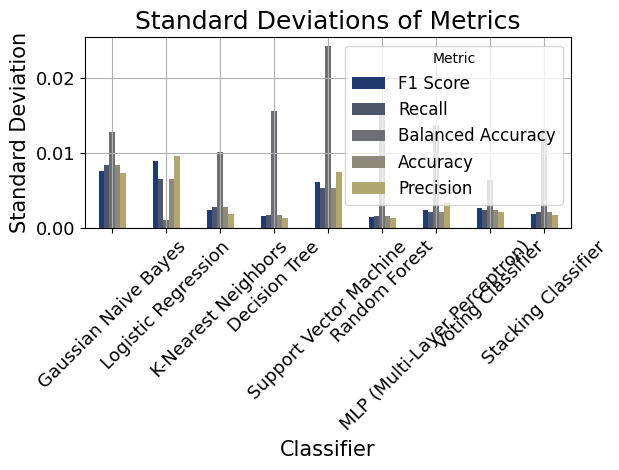

In [60]:
import matplotlib.pyplot as plt

# Plotting standard deviations
plt.figure(figsize=(10, 6))
results_std.plot(kind='bar', rot=45)
plt.title('Standard Deviations of Metrics')
plt.xlabel('Classifier')
plt.ylabel('Standard Deviation')
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()



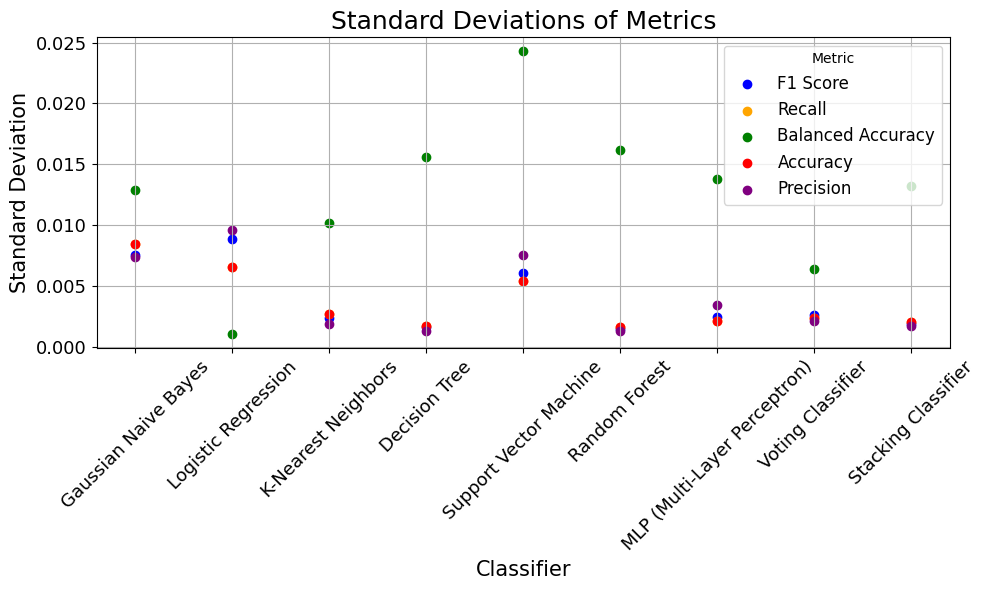

In [61]:
import matplotlib.pyplot as plt

# Define colors for each metric
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plotting standard deviations
plt.figure(figsize=(10, 6))
for i, metric in enumerate(results_std.columns):
    if i < len(colors):
        plt.scatter(results_std.index, results_std[metric], color=colors[i], label=metric)
    else:
        plt.scatter(results_std.index, results_std[metric], label=metric)
plt.title('Standard Deviations of Metrics')
plt.xlabel('Classifier')
plt.ylabel('Standard Deviation')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [62]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score

# Initialize an empty list to store dictionaries of metrics
results_list = []

# Loop through each classifier and its corresponding metrics
for name, metric in metrics.items():
    # Encode predictions to ensure consistency
    pred_encoded = label_encoder.transform(predictions[name])
    
    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test_encoded, pred_encoded)
    
    # Append the metrics to the list
    results_list.append({
        'Classifier': name,
        'F1 Score': metric['F1 Score'],
        'Recall': metric['Recall'],
        'Balanced Accuracy': balanced_acc,
        'Accuracy': metric['Accuracy'],
        'Precision': metric['Precision'],
        'Confusion Matrix': metric['Confusion Matrix'],
        'Classification Report': metric['Classification Report']
    })

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_list)

# Print the DataFrame
# print(results_df)
results_df


,Classifier,F1 Score,Recall,Balanced Accuracy,Accuracy,Precision,Confusion Matrix,Classification Report
0,Gaussian Naive Bayes,0.741773,0.757940,0.243810,0.757940,0.748563,"[[2824, 2, 0, 0, 0, 474, 15, 11, 0, 0], [15, 4...",precision recall f1-score ...
1,Logistic Regression,0.703782,0.764065,0.124348,0.764065,0.661084,"[[3199, 0, 3, 0, 0, 124, 0, 0, 0, 0], [16, 0, ...",precision recall f1-score ...
2,K-Nearest Neighbors,0.950159,0.949864,0.890838,0.949864,0.951194,"[[3209, 0, 28, 2, 4, 62, 1, 16, 3, 1], [1, 22,...",precision recall f1-score ...
3,Decision Tree,0.937867,0.937613,0.850697,0.937613,0.938836,"[[3192, 0, 30, 2, 1, 85, 0, 14, 2, 0], [2, 20,...",precision recall f1-score ...
4,Support Vector Machine,0.873234,0.884982,0.637541,0.884982,0.882544,"[[3209, 2, 3, 1, 4, 88, 4, 14, 0, 1], [5, 18, ...",precision recall f1-score ...
5,Random Forest,0.949423,0.949410,0.889985,0.949410,0.949832,"[[3225, 0, 21, 2, 1, 60, 0, 14, 3, 0], [1, 22,...",precision recall f1-score ...
6,MLP (Multi-Layer Perceptron),0.907625,0.913566,0.765021,0.913566,0.913148,"[[3192, 2, 3, 1, 9, 94, 4, 8, 13, 0], [4, 19, ...",precision recall f1-score ...
7,Voting Classifier,0.936815,0.940336,0.802246,0.940336,0.939593,"[[3251, 0, 6, 1, 1, 57, 0, 10, 0, 0], [1, 22, ...",precision recall f1-score ...
8,Stacking Classifier,0.948098,0.948276,0.881840,0.948276,0.948731,"[[3221, 0, 16, 1, 4, 63, 4, 14, 3, 0], [1, 22,...",precision recall f1-score ...


In [63]:
# Convert standard deviations to percentages for each classifier
results_std_percentage = results_std.apply(lambda x: x * 100)

# Print or use the DataFrame with percentages
print("Standard Deviations as Percentages:")
print(results_std_percentage)


Standard Deviations as Percentages:
                              F1 Score    Recall  Balanced Accuracy  Accuracy  \
Gaussian Naive Bayes          0.757848  0.844862           1.288094  0.844862   
Logistic Regression           0.888243  0.658068           0.107291  0.658068   
K-Nearest Neighbors           0.238879  0.273596           1.017954  0.273596   
Decision Tree                 0.161183  0.174282           1.556461  0.174282   
Support Vector Machine        0.610022  0.539945           2.426972  0.539945   
Random Forest                 0.149730  0.162782           1.616581  0.162782   
MLP (Multi-Layer Perceptron)  0.245492  0.212107           1.376671  0.212107   
Voting Classifier             0.259576  0.238878           0.635562  0.238878   
Stacking Classifier           0.188948  0.205874           1.322595  0.205874   

                              Precision  
Gaussian Naive Bayes           0.734826  
Logistic Regression            0.957445  
K-Nearest Neighbors        

In [5]:
df.columns

Index(['Unnamed: 0', 'textid', 'Date', 'Views', 'sourcetype', 'alltext',
       'Text_emt', 'Text_emj', 'Text_langue', 'Text_translate', 'Text_langue2',
       'Text_lower', 'Text_punct', 'Text_tags', 'Text_chat', 'Text_spell',
       'Text_langue3', 'Text_translate2', 'Text_token', 'Text_stop',
       'Text_stem', 'Text_lemma', 'berttopic2', 'cluster_id2',
       'llama2_labelone10', 'cluster_labelone10', 'cluster_id',
       'llama2_labelone', 'cluster_labelone'],
      dtype='object')

In [6]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Convert 'label_llama2' column to a list
topics_list = df['llama2_labelone10'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)

# Compute coherence score using CoherenceModel (C_v)
coherence_model_cv = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_cv_score = coherence_model_cv.get_coherence()

# Compute coherence score using CoherenceModel (NPMI)
coherence_model_npmi = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_npmi')
coherence_npmi_score = coherence_model_npmi.get_coherence()

# Compute coherence score using CoherenceModel (Umass)
coherence_model_umass = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='u_mass')
coherence_umass_score = coherence_model_umass.get_coherence()

# # Save results to a text file
# output_file = "coherence_scores_gensimwsp2.txt"
# with open(output_file, "w") as file:
#     file.write("Coherence Score_wordwsp1 (CV): {}\n".format(coherence_cv_score))
#     file.write("Coherence Score_wordwsp1 (NPMI): {}\n".format(coherence_npmi_score))
#     file.write("Coherence Score_wordwsp1 (Umass): {}\n".format(coherence_umass_score))

# # print("Results saved to:", output_file)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [7]:
print("Coherence Score_llama (NPMI):", coherence_npmi_score)

Coherence Score_llama (NPMI): 0.22485670843829553


In [8]:
print("Coherence Score_llama (CV):", coherence_cv_score)

Coherence Score_llama (CV): 0.7028467725863129


In [9]:
print("Coherence Score_llama (Umass):", coherence_umass_score)


Coherence Score_llama (Umass): -2.632214304364452


In [53]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Convert 'label_llama2' column to a list
topics_list = df['cluster_labelone10'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)

# Compute coherence score using CoherenceModel (C_v)
coherence_model_cv = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_cv_score = coherence_model_cv.get_coherence()

# Compute coherence score using CoherenceModel (NPMI)
coherence_model_npmi = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='c_npmi')
coherence_npmi_score = coherence_model_npmi.get_coherence()

# Compute coherence score using CoherenceModel (Umass)
coherence_model_umass = CoherenceModel(topics=topics_list, texts=documents, dictionary=dictionary, coherence='u_mass')
coherence_umass_score = coherence_model_umass.get_coherence()

print("Coherence Score_word (NPMI):", coherence_npmi_score)
print("Coherence Score_word (CV):", coherence_cv_score)
print("Coherence Score_word (Umass):", coherence_umass_score)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Coherence Score_word (NPMI): 0.2702469481463623
Coherence Score_word (CV): 0.7632369085719629
Coherence Score_word (Umass): -1.7970379267564895


In [11]:
from contextualized_topic_models.evaluation.measures import InvertedRBO
from gensim.corpora.dictionary import Dictionary

# Convert 'label_llama2' column to a list
topics_list = df['cluster_labelone'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)
irbo_ctm = InvertedRBO(topics=topics_list)
print("coherence score IRBO:", irbo_ctm.score())

coherence score IRBO: 0.580497743348262


In [13]:
from contextualized_topic_models.evaluation.measures import InvertedRBO
from gensim.corpora.dictionary import Dictionary
topk=10

# Convert 'label_llama2' column to a list
topics_list = df['llama2_labelone10'].tolist()

# Convert documents to a list of tokenized documents
documents = df['Text_lemma'].tolist()
documents = [doc.split() for doc in documents]

# Convert documents to a Gensim dictionary
dictionary = Dictionary(documents)
# irbo_ctm = InvertedRBO(topics=topics_list)
# print("coherence score IRBO:", irbo_ctm.score())
# Filter out topics with fewer words than topk
topics_list_filtered = [topic for topic in topics_list if len(topic.split()) >= topk]

# Calculate the coherence score
irbo_ctm = InvertedRBO(topics=topics_list_filtered)
print("coherence score IRBO:", irbo_ctm.score(topk=topk))

coherence score IRBO: 0.4330602408315972


In [ ]:
# df.to_csv('BERT_CTFIDFwsp2.csv')#, index=False)


In [ ]:
# df.shape